<a href="https://colab.research.google.com/github/prysykes/trevec/blob/main/clip_video_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add sort the clusters according to homogeinity of the members in the final UI. You can have confidence score (80, 60) as a super group for each cluster group

In [ ]:
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git
# !pip install opencv-python-headless
# !pip install einops
# !pip install moviepy
# !pip install transformers
# !pip install hyperopt
# !pip install umap-learn
# !pip install tf-keras
# !pip install scipy
# !pip install seaborn
# !pip install ffmpeg
# !pip install hyperopt

In [ ]:
import torch, torchvision
import numpy as np
import pandas as pd
import sklearn
import random
import os
import cv2
import glob
import regex
import einops
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
# from tqdm import tqdm
from torchvision.transforms import v2

In [ ]:
from collections import Counter

In [ ]:
from transformers import pipeline
from hdbscan import HDBSCAN

In [ ]:
print(f"Pytorch version: {torch.__version__}")
print(f"Is GPU available {torch.cuda.is_available()}")

Pytorch version: 2.2.1+cu121
Is GPU available True


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
import clip

In [ ]:
model, preprocess = clip.load('ViT-B/32', device)

In [ ]:
full_video_path = 'trecvid_videos'
processed_files = '/content/processed_files'
print(os.path.isdir(full_video_path)), print(os.path.isdir(processed_files))

True
True


(None, None)

In [ ]:
all_videos = glob.glob(f"{full_video_path}/*.webm")
all_videos = sorted(all_videos, key=lambda x: int(x.split('/')[-1].split('.')[0]))

In [ ]:
## Sanity Check

for idx, vid_file in enumerate(all_videos):
  if idx == 3:
    break
  print(vid_file)

trecvid_videos/9001.webm
trecvid_videos/9002.webm
trecvid_videos/9003.webm


In [ ]:
a_video_sample = random.choice(all_videos)
print("a_video_sample:", a_video_sample)

a_video_sample: trecvid_videos/16242.webm


In [ ]:
# Set enviroment variable for MOVICLIP
os.environ['IMAGEIO_FFMPEG_EXE'] = 'ffmpeg'

print(os.getenv('IMAGEIO_FFMPEG_EXE'))

ffmpeg


In [ ]:
from moviepy.editor import VideoFileClip
from PIL import Image

In [ ]:
def get_frames(video_path, frame_rate=1):
  """
    Extracts some frames from a video file
    args: video_path vide file path
          frame_rate number of frame to take per sec
    returns: tuple of (filename, batchOfFrame)
  """
  file_name = video_path.split('/')[-1]
  clip = clip = VideoFileClip(video_path)
  frames = [frame for frame in clip.iter_frames(fps=frame_rate, dtype='uint8')]

  clip.close()
  return (file_name, frames)


In [ ]:
print(os.environ)

environ({'SHELL': '/bin/bash', 'NV_LIBCUBLAS_VERSION': '12.2.5.6-1', 'NVIDIA_VISIBLE_DEVICES': 'all', 'NV_NVML_DEV_VERSION': '12.2.140-1', 'NV_CUDNN_PACKAGE_NAME': 'libcudnn8', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.19.3-1+cuda12.2', 'NV_LIBNCCL_DEV_PACKAGE_VERSION': '2.19.3-1', 'VM_GCE_METADATA_HOST': '169.254.169.254', 'HOSTNAME': 'f4bdfb85e431', 'LANGUAGE': 'en_US', 'COLAB_TPU_1VM': '', 'NVIDIA_REQUIRE_CUDA': 'cuda>=12.2 brand=tesla,driver>=470,driver<471 brand=unknown,driver>=470,driver<471 brand=nvidia,driver>=470,driver<471 brand=nvidiartx,driver>=470,driver<471 brand=geforce,driver>=470,driver<471 brand=geforcertx,driver>=470,driver<471 brand=quadro,driver>=470,driver<471 brand=quadrortx,driver>=470,driver<471 brand=titan,driver>=470,driver<471 brand=titanrtx,driver>=470,driver<471 brand=tesla,driver>=525,driver<526 brand=unknown,driver>=525,driver<526 brand=nvidia,driver>=525,driver<526 brand=nvidiartx,driver>=525,driver<526 brand=geforce,driver>=525,driver<526 brand=geforcer

In [ ]:
file_name_frames = get_frames(a_video_sample, frame_rate=2)

In [ ]:
filen_ame, f_rames = file_name_frames[0], file_name_frames[1]
processed_frames_ = [preprocess(Image.fromarray(frame)).unsqueeze(0).to(device) for frame in f_rames]

In [ ]:
for frame in processed_frames_:
  print(frame.shape)
  break

torch.Size([1, 3, 224, 224])


In [ ]:
with torch.no_grad():
  embeddings = [model.encode_image(frame).squeeze(0) for frame in processed_frames_]
  embeddings = torch.stack(embeddings, axis=0)
  average_embeddings = torch.reshape(torch.mean(embeddings, axis=0), shape=(1, -1))

In [ ]:
average_embeddings.shape

torch.Size([1, 512])

In [ ]:
print(len(file_name_frames[1]))

12


In [ ]:
sample_image_from_frames = Image.fromarray(file_name_frames[1][0])


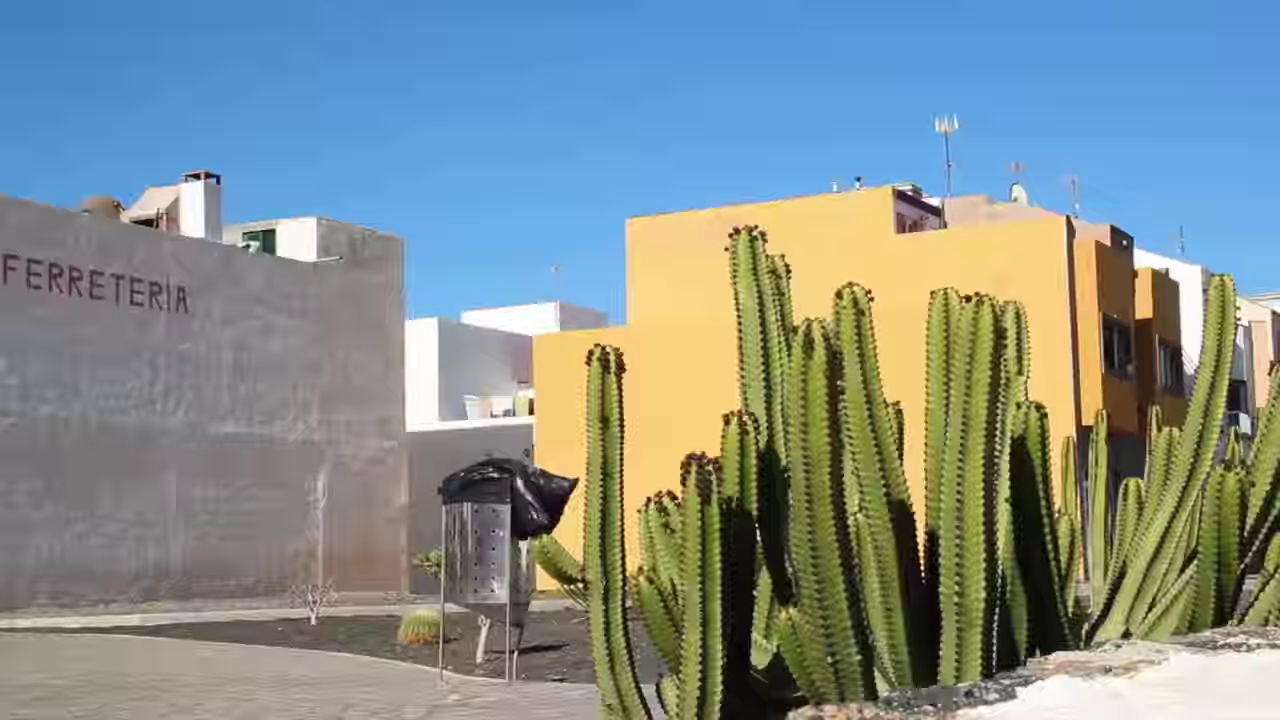

In [ ]:
sample_image_from_frames

In [ ]:
class ClipExtractandEncode():
    """
        Extracts the embeddings from the frames of a video clip
        Args:
            clip_model: clip model instance
            video_paths: list of video path
            frame_rate: determins the fps
            average: Bool default is True
            returns: the average of the frame embeddings if average is True
                    or embeddings row stacked
    """
    def __init__(self, clip_model, video_paths, frame_rate, average=True):
        self.clip_model = clip_model
        self.video_paths = video_paths
        self.frame_rate = frame_rate
        self.average = average
        self.vidname_embeds = []
        self.vidname_embeds_avg = []
        self.bad_videos = {}


    def get_frames(self):
        counter = 1
        for idx in tqdm(range(len(self.video_paths))):
            video_path = self.video_paths[idx]
            file_name = video_path.split('/')[-1]

            try:
              video_clip = VideoFileClip(video_path)
              # print('yes', video_clip)
              # self.vidname_embeds[file_name] = None

              frames = [frame for frame in video_clip.iter_frames(fps=self.frame_rate, dtype='uint8')]
              video_clip.close()

              processed_frames = [preprocess(Image.fromarray(frame)).unsqueeze(0).to(device) for frame in frames]
              with torch.no_grad():
                  embeddings = [self.clip_model.encode_image(frame).squeeze(0) for frame in processed_frames]
                  if self.average:
                      stacked_embeddings = torch.stack(embeddings, axis=0)
                      average_embeddings = torch.reshape(torch.mean(stacked_embeddings, axis=0), shape=(1, -1)).numpy(force=True)
                      average_embeddings = np.squeeze(average_embeddings).tolist()
                      avg_cur_load = {'file_names': file_name, 'embeddings': average_embeddings}
                      self.vidname_embeds_avg.append(avg_cur_load)
                      # print('yes', self.vidname_embeds_avg)
                  # else:
                  # embeddings = np.asarray([list(emb.to("cpu")) for emb in embeddings])
                  embeddings = np.asarray([emb.to("cpu") for emb in embeddings]).tolist()
                  # embeddings = [emb.to("cpu") for emb in embeddings]
                  cur_load = {'file_names': file_name, 'embeddings': embeddings}
                  self.vidname_embeds.append(cur_load)
                  # print('no', self.vidname_embeds)

                  # self.vidname_embeds[file_name] = embeddings
            except:
              # print('baaad', counter, file_name)
              self.bad_videos[counter] = file_name
              counter += 1

        return (self.vidname_embeds_avg, self.vidname_embeds, self.bad_videos)
            # return self.vidname_embeds
    def __call__(self):
        return self.get_frames()

In [ ]:
print(len(all_videos))

9000


In [ ]:
clip_extract_encode = ClipExtractandEncode(clip_model=model,
                                           video_paths=all_videos,
                                           frame_rate=1,
                                           average=True)

In [ ]:
file_frames_bad_vids = clip_extract_encode() #9124 bad

In [ ]:
filenames_frames_avg_, filenames_frames_flatten_, bad_video_files_ = file_frames_bad_vids[0], file_frames_bad_vids[1], file_frames_bad_vids[2]

In [ ]:
print(len(bad_video_files_)), print(len(filenames_frames_avg_), len(filenames_frames_flatten_))

34
8966 8966


(None, None)

In [ ]:
for item in filenames_frames_avg_:
  print(item)
  break

{'file_names': '9001.webm', 'embeddings': [-0.04388427734375, 0.068603515625, -0.30419921875, 0.0233917236328125, 0.04522705078125, -0.42431640625, 0.2091064453125, 0.0897216796875, 0.3115234375, 0.53271484375, 0.2371826171875, -0.58837890625, 0.377685546875, -0.058990478515625, 0.11737060546875, -0.57177734375, -0.84423828125, -0.479736328125, 0.088623046875, 0.0005464553833007812, 0.0245208740234375, 0.234130859375, 0.244873046875, 0.1531982421875, -0.1640625, 0.0755615234375, 0.1923828125, 0.0078277587890625, -0.10211181640625, -0.06280517578125, -0.1605224609375, 0.2255859375, 0.07598876953125, 0.04534912109375, -0.406494140625, 0.032684326171875, -0.10198974609375, -0.1663818359375, 0.10345458984375, 0.55859375, -0.302490234375, 0.51025390625, -0.209228515625, -0.0831298828125, 0.172119140625, 1.5400390625, 0.271484375, 0.04345703125, -0.1839599609375, 0.27490234375, -0.1373291015625, -0.055694580078125, 0.5400390625, -0.091064453125, -0.08123779296875, 0.0711669921875, -0.5332031

In [ ]:
field_names = ['file_names', 'embeddings']

In [ ]:
clip_embeddings_with_av = os.path.join(processed_files, 'clip_embeddings_with_av.csv')
clip_embeddings_raw = os.path.join(processed_files, 'clip_embeddings_raw.csv')
bad_files = os.path.join(processed_files, 'bad_files.json')

In [ ]:
import csv

In [ ]:
# with open(clip_embeddings_raw, 'w') as csv_file:
#   # print('yes')
#   writer = csv.DictWriter(csv_file, fieldnames=field_names)
#   writer.writeheader()
#   writer.writerows(filenames_frames_flatten_)

In [ ]:
# with open(clip_embeddings_with_av, 'w') as csv_file:
#   writer = csv.DictWriter(csv_file, fieldnames=field_names)
#   writer.writeheader()
#   writer.writerows(filenames_frames_avg_)


In [ ]:
import json

In [ ]:
for k, v in bad_video_files_.items():
  print(k,v)
  break

1 9077.webm


In [ ]:
with open(bad_files, 'w') as json_file:
  json.dump(bad_video_files_, json_file)


In [ ]:
from ast import literal_eval

In [ ]:
df = pd.read_csv(clip_embeddings_with_av, converters={'embeddings': literal_eval})

In [ ]:
df.head(5)

,file_names,embeddings
0,9001.webm,"[-0.04388427734375, 0.068603515625, -0.3041992..."
1,9002.webm,"[0.33203125, -0.3603515625, -0.019439697265625..."
2,9003.webm,"[-0.45068359375, -0.09588623046875, 0.33398437..."
3,9004.webm,"[0.0684814453125, -0.130859375, 0.08642578125,..."
4,9005.webm,"[-0.2315673828125, 0.0158843994140625, -0.0168..."


In [ ]:
df.count()

file_names    8966
embeddings    8966
dtype: int64

In [ ]:
exploded_df = pd.DataFrame(df['embeddings'].to_list(), columns=[f'{i}' for i in range(len(df['embeddings'].max()))])

In [ ]:
exploded_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.043884,0.068604,-0.304199,0.023392,0.045227,-0.424316,0.209106,0.089722,0.311523,0.532715,...,-0.023499,0.257324,-0.025894,0.101746,0.253174,0.134766,-0.444336,0.552734,0.062317,-0.230469
1,0.332031,-0.360352,-0.019440,0.005394,0.140747,0.090576,0.057709,0.108093,0.329590,-0.103516,...,-0.188965,0.307617,-0.038208,0.018585,-0.013138,-0.048706,-0.075989,0.598145,0.012634,0.100830
2,-0.450684,-0.095886,0.333984,-0.004158,-0.288086,-0.516602,-0.103882,0.189209,-0.270020,0.311768,...,-0.112671,0.002571,-0.132446,0.000528,-0.151855,0.176758,0.210449,0.528809,-0.148315,-0.344238
3,0.068481,-0.130859,0.086426,0.157349,0.166382,-0.146362,0.013557,0.360596,-0.027161,0.176270,...,-0.002953,-0.091553,0.214233,-0.259277,0.075439,-0.054413,0.029938,0.020905,-0.121155,-0.271973
4,-0.231567,0.015884,-0.016861,-0.132446,0.246094,-0.084595,-0.006428,0.278564,-0.264404,-0.303711,...,0.102234,0.002697,0.312012,-0.247437,0.151123,-0.204346,-0.164307,-0.012321,-0.527832,0.343750


## Reduce Dimensions

In [ ]:
import umap
from hdbscan import HDBSCAN

In [ ]:
def generate_clusters(video_embeddings,
                      n_neighbors,
                      n_components,
                      min_cluster_size,
                      random_state=None):
  """
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
  """
  umap_embeddings = (umap.UMAP(
      n_neighbors=n_neighbors,
      n_components=n_components,
      metric='cosine',
      random_state=random_state).fit_transform(video_embeddings))

  hdbscan = HDBSCAN(min_cluster_size=min_cluster_size,
                            metric='euclidean',
                            cluster_selection_method='eom')
  clusters = hdbscan.fit(umap_embeddings)

  return clusters

In [ ]:
# try hdbscan
clusters = generate_clusters(video_embeddings=exploded_df,
                        n_neighbors=12,
                        n_components=9,
                        min_cluster_size=10,
                        random_state=42)

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



In [ ]:
cluster_ids = np.asarray(clusters.labels_)
cluster_ids = np.reshape(cluster_ids, (-1, 1))

In [ ]:
print(len(np.unique(cluster_ids)))

14


## Bayesian Search for hyper parameters

In [ ]:
space = {
    "n_neighbors": range(5, 50),
    "n_components": range(3, 10),
    "min_cluster_size": range(50, 200),
    "random_state": 42
}

In [ ]:
LABEL_LOWER = 50 #minimum number of clusters you need


In [ ]:
def score_clusters(clusters, prob_threshold=0.05):
  """
    Returns the label count and the cost of a given cluster from hdbscan
    Label count takes cluster labels

  """
  cluster_labels = clusters.labels_
  label_count = len(np.unique(cluster_labels))
  total_num_clusters = len(cluster_labels)
  cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num_clusters)

  return label_count, cost


In [ ]:
from functools import partial
from hyperopt import fmin, space_eval, tpe, hp, STATUS_OK, Trials

In [ ]:
def objective(params, video_embeddings, label_lower, label_upper):
  """
    Objective function for hyperopt to minimize the cost constraints
    on the number of clusters above out set threshold
  """

  clusters = generate_clusters(video_embeddings=video_embeddings,
                        n_neighbors=params['n_neighbors'],
                        n_components=params['n_components'],
                        min_cluster_size=params['min_cluster_size'],
                        random_state=params['random_state'])
  label_count, cost = score_clusters(clusters=clusters)

  if (label_count < label_lower) or (label_count > label_upper):
    penalty=0.15
  else:
    penalty=0
  loss = cost + penalty
  return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [ ]:
def baysian_search(video_embeddings, space, label_lower, label_upper, max_evals=100):
  """
    Perform baysian search on hyperparameter space minimize Obj function
  """

  trials = Trials()
  fmin_objective = partial(objective, video_embeddings=video_embeddings,
                           label_lower=label_lower, label_upper=label_upper)

  best = fmin(fmin_objective,
              space=space,
              algo=tpe.suggest,
              max_evals=max_evals,
              trials=trials)
  best_param = space_eval(space, best)

  best_clusters = generate_clusters(video_embeddings=video_embeddings,
                                    n_neighbors=best_param['n_neighbors'],
                                    n_components=best_param['n_components'],
                                    min_cluster_size=best_param['min_cluster_size'],
                                    random_state=best_param['random_state'])
  return best_param, best_clusters, trials


In [ ]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3, 30)),
    "n_components": hp.choice('n_components', range(3, 30)),
    "min_cluster_size": hp.choice('min_cluster_size', range(2, 100)),
    "random_state": 42
}

label_lower = 10
label_upper = 100
max_evals = 50

In [ ]:
best_params, best_clusters_use, trials_use = baysian_search(exploded_df,
                                                            space=hspace,
                                                            label_lower=label_lower,
                                                            label_upper=label_upper,
                                                            max_evals=max_evals)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  2%|▏         | 1/50 [00:50<40:53, 50.07s/trial, best loss: 0.15970332366718715]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  4%|▍         | 2/50 [01:39<39:36, 49.51s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  6%|▌         | 3/50 [02:05<30:31, 38.96s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  8%|▊         | 4/50 [02:46<30:28, 39.75s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 10%|█         | 5/50 [03:18<27:35, 36.80s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 12%|█▏        | 6/50 [03:48<25:25, 34.67s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 14%|█▍        | 7/50 [04:13<22:36, 31.55s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 16%|█▌        | 8/50 [04:33<19:23, 27.70s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 18%|█▊        | 9/50 [04:49<16:27, 24.09s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 20%|██        | 10/50 [05:18<17:03, 25.59s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 22%|██▏       | 11/50 [05:38<15:35, 23.97s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 24%|██▍       | 12/50 [05:53<13:27, 21.24s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 26%|██▌       | 13/50 [06:10<12:22, 20.06s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 28%|██▊       | 14/50 [06:31<12:12, 20.35s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 30%|███       | 15/50 [06:58<12:57, 22.22s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 32%|███▏      | 16/50 [07:52<18:00, 31.78s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 34%|███▍      | 17/50 [08:20<16:51, 30.65s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 36%|███▌      | 18/50 [08:59<17:44, 33.28s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 38%|███▊      | 19/50 [09:26<16:05, 31.14s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 40%|████      | 20/50 [09:56<15:22, 30.76s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 42%|████▏     | 21/50 [10:23<14:22, 29.74s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 44%|████▍     | 22/50 [11:00<14:54, 31.96s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 46%|████▌     | 23/50 [11:24<13:18, 29.56s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 48%|████▊     | 24/50 [11:45<11:40, 26.93s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 50%|█████     | 25/50 [12:38<14:30, 34.83s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 52%|█████▏    | 26/50 [13:10<13:32, 33.84s/trial, best loss: 0.15423823332589784]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 54%|█████▍    | 27/50 [13:55<14:20, 37.43s/trial, best loss: 0.15312290876645104]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 56%|█████▌    | 28/50 [14:41<14:40, 40.01s/trial, best loss: 0.15312290876645104]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 58%|█████▊    | 29/50 [15:23<14:10, 40.48s/trial, best loss: 0.15312290876645104]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 60%|██████    | 30/50 [15:52<12:21, 37.09s/trial, best loss: 0.15312290876645104]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 62%|██████▏   | 31/50 [16:39<12:40, 40.04s/trial, best loss: 0.15312290876645104]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 64%|██████▍   | 32/50 [17:08<11:01, 36.77s/trial, best loss: 0.15312290876645104]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 66%|██████▌   | 33/50 [17:38<09:47, 34.57s/trial, best loss: 0.15312290876645104]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 68%|██████▊   | 34/50 [18:02<08:26, 31.65s/trial, best loss: 0.15]               

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 70%|███████   | 35/50 [18:27<07:24, 29.65s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 72%|███████▏  | 36/50 [18:52<06:34, 28.20s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 74%|███████▍  | 37/50 [19:17<05:52, 27.13s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 76%|███████▌  | 38/50 [19:45<05:27, 27.31s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 78%|███████▊  | 39/50 [19:58<04:13, 23.07s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 80%|████████  | 40/50 [20:27<04:08, 24.87s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 82%|████████▏ | 41/50 [21:01<04:09, 27.77s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 84%|████████▍ | 42/50 [21:36<03:57, 29.70s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 86%|████████▌ | 43/50 [22:10<03:37, 31.12s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 88%|████████▊ | 44/50 [22:30<02:47, 27.86s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 90%|█████████ | 45/50 [23:01<02:23, 28.70s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 92%|█████████▏| 46/50 [23:36<02:02, 30.58s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 94%|█████████▍| 47/50 [24:03<01:28, 29.40s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 96%|█████████▌| 48/50 [24:54<01:11, 35.86s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 98%|█████████▊| 49/50 [25:09<00:29, 29.77s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



100%|██████████| 50/50 [25:42<00:00, 30.85s/trial, best loss: 0.15]

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



In [ ]:
best_params

{'min_cluster_size': 15,
 'n_components': 25,
 'n_neighbors': 13,
 'random_state': 42}

In [ ]:
best_params

{'min_cluster_size': 52,
 'n_components': 4,
 'n_neighbors': 25,
 'random_state': 42}

In [ ]:
reducer = umap.UMAP(random_state=best_params['random_state'],
                    n_components=15,
                    n_neighbors=10)

In [ ]:
video_embeddings_reduced = reducer.fit_transform(exploded_df)

  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



In [ ]:
video_embeddings_reduced[0], video_embeddings_reduced[0].size

(array([10.258996 ,  9.126045 ,  9.133496 ,  9.137521 ,  0.6836187,
         4.1547318,  7.121361 ,  3.3762257,  1.6960976,  4.7598286,
         9.457704 ,  4.343698 ,  9.130829 ,  8.03075  ,  5.8090243],
       dtype=float32),
 15)

## Optimized Cluster V2

In [ ]:
# class Recluster():
#   def __init__(self, original_df, lower_min_cluster_size, upper_min_cluster_size, lower_limit):
#     self.original_df = original_df
#     self.lower_min_cluster_size = lower_min_cluster_size
#     self.upper_min_cluster_size = upper_min_cluster_size
#     self.default_upper_min_cluster_size = upper_min_cluster_size
#     self.min_cluster_size = None
#     self.lower_limit = lower_limit
#     self.current_noise = None
#     self.final_clusters = pd.DataFrame()
#     self.large_clusters = {} #{cluster_id: cluster}
#     self.count = 1
#     self.start = False
#     self.run = True

#   def explode_embeddings(self, embeddings_df):
#     print("embeddings_df.shape", embeddings_df.shape)
#     exploded_df = pd.DataFrame(embeddings_df['embeddings'].to_list(),
#                                columns=[f"{i}" for i in range(len(embeddings_df['embeddings'].max()))])
#     print("explode_rem done...")
#     return exploded_df

#   def reassign_cluster_idx(self, count, embeddings_df):
#     # extract final_clusters cluster_ids
#     cluster_ids = embeddings_df['cluster_id']
#     # update current cluster_ids
#     new_embeddings_df = np.array([f"{count}_{idx}" for idx in list(cluster_ids)])
#     # print("new_cur_clusters", new_cur_clusters)
#     # update final_clusters

#     embeddings_df = embeddings_df.drop('cluster_id', axis=1)
#     embeddings_df['cluster_id'] = embeddings_df
#     return embeddings_df

#   def compare_to_lower_limit(self, count, cluster_ids_and_size, not_noise):
#     print("Comparing cluster to lower limit")
#     for idx, size in cluster_ids_and_size.items():
#       if size <= self.lower_limit:
#         lower_size = not_noise[not_noise['cluster_id']== idx]
#         # update cluster id of lower_size
#         lower_size = self.reassign_cluster_idx(count, lower_size)
#         # update self.final_clusters with this
#         self.final_clusters = pd.concat([self.final_clusters, lower_size], ignore_index=True)
#       else:
#         larger_size = not_noise[not_noise['cluster_id']==idx]
#         # update large_clusters
#         self.large_clusters[idx] = larger_size


#   def cluster_embeddings(self, count, exploded_embeddings, embeddings_df):
#     # instantiate HDBSCAN
#     hdbscan = HDBSCAN(self.upper_min_cluster_size)
#     cur_cluster_ids = hdbscan.fit_predict(exploded_embeddings)
#     cluster_ids_and_size = dict(Counter(cur_cluster_ids))
#     # drop the cluster_ids from embeddings_df
#     # and and the new cluster ids
#     embeddings_df_droped = embeddings_df.drop('cluster_id', axis=1)
#     embeddings_df_droped['cluster_id'] = cur_cluster_ids
#     # extract noise and set self.current_noise
#     cur_noise = embeddings_df_droped[embeddings_df_droped['cluster_id'] == -1]
#     self.current_noise = cur_noise
#     # extract other clusters
#     not_noise = embeddings_df_droped[embeddings_df_droped['cluster_id'] != -1]
#     # now loop through this not_noise and extract cluster larger than lower_limit
#     # and add them to self.large_clusters
#     # other clusters that are less than the lower_limit, add them to
#     # final clusters
#     self.compare_to_lower_limit(count, cluster_ids_and_size, not_noise)
#     return self.current_noise

#   def __call__(self):
#     while self.run:
#       if not self.start:
#         exploded_embeddings = self.explode_embeddings(self.original_df)
#         self.current_noise = self.cluster_embeddings(exploded_embeddings, self.original_df)
#         self.start = True
#       else:
#         # here we have set self.current_noise
#         # this loop runs until the size of the noise is
#         # less than lower limit
#         while len(self.current_noise.index) > self.lower_limit:
#           if self.upper_min_cluster_size < self.lower_min_cluster_size:
#             # check if noise is empty dataframe
#             if self.current_noise.empty():
#               break
#             else:
#               # update final_cluster with noise and break out of this loop
#               self.final_clusters = pd.concat([self.final_clusters, self.current_noise], ignore_index=True)
#               break
#           # reduce the min_cluster_size until its == to
#           self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))
#           # explode current noise
#           exploded_embeddings = self.explode_embeddings(self.current_noise)
#           # cluster current noise
#           self.current_noise = self.cluster_embeddings(self.count, exploded_embeddings, self.current_noise)
#           self.count += 1
#         self.run = False
#       return self.final_clusters, self.large_clusters


## cluster using HDBSCAN

In [ ]:
best_params['min_cluster_size']

52

In [ ]:
# try Kmeans and recluster the noise in each case

In [ ]:
hdbscan = HDBSCAN(20) #good 10

In [ ]:
clusters = hdbscan.fit_predict(exploded_df)
unique_cluster_ids = np.unique(clusters)

In [ ]:
print(type(clusters))

<class 'numpy.ndarray'>


In [ ]:
new_df = df.copy()
new_df['cluster_id'] = clusters

In [ ]:
new_df.head(5)

,file_names,embeddings,cluster_id
0,9001.webm,"[-0.04388427734375, 0.068603515625, -0.3041992...",-1
1,9002.webm,"[0.33203125, -0.3603515625, -0.019439697265625...",0
2,9003.webm,"[-0.45068359375, -0.09588623046875, 0.33398437...",-1
3,9004.webm,"[0.0684814453125, -0.130859375, 0.08642578125,...",-1
4,9005.webm,"[-0.2315673828125, 0.0158843994140625, -0.0168...",-1


In [ ]:
all_except_neg_1_one = new_df[new_df['cluster_id'] != -1]

all_except_neg_1_one.head(5)

,file_names,embeddings,cluster_id
1,9002.webm,"[0.33203125, -0.3603515625, -0.019439697265625...",0
6,9007.webm,"[-0.126220703125, -0.06878662109375, 0.2893066...",0
8,9009.webm,"[-0.63330078125, 0.10125732421875, -0.08648681...",0
13,9014.webm,"[-0.185546875, 0.1337890625, 0.124755859375, -...",0
15,9016.webm,"[-0.09515380859375, 0.007358551025390625, 0.28...",0


In [ ]:
len(all_except_neg_1_one['cluster_id'])

2537

In [ ]:
rem_clusters = new_df[new_df['cluster_id'] == -1]

len(rem_clusters.index)

8336

In [ ]:
rem_clusters.head(5)

,file_names,embeddings,cluster_id
0,9001.webm,"[-0.04388427734375, 0.068603515625, -0.3041992...",-1
1,9002.webm,"[0.33203125, -0.3603515625, -0.019439697265625...",-1
2,9003.webm,"[-0.45068359375, -0.09588623046875, 0.33398437...",-1
3,9004.webm,"[0.0684814453125, -0.130859375, 0.08642578125,...",-1
4,9005.webm,"[-0.2315673828125, 0.0158843994140625, -0.0168...",-1


In [ ]:
rem_clusters_ = rem_clusters.drop('cluster_id', axis=1)
rem_clusters_.head(5)

,file_names,embeddings
0,9001.webm,"[-0.04388427734375, 0.068603515625, -0.3041992..."
1,9002.webm,"[0.33203125, -0.3603515625, -0.019439697265625..."
2,9003.webm,"[-0.45068359375, -0.09588623046875, 0.33398437..."
3,9004.webm,"[0.0684814453125, -0.130859375, 0.08642578125,..."
4,9005.webm,"[-0.2315673828125, 0.0158843994140625, -0.0168..."


In [ ]:
#explode rem_clusters
def explode_rem_clusters_df(df):
  exploded_rem_clusters = pd.DataFrame(df['embeddings'].to_list(), columns=[f'{i}' for i in range(len(df['embeddings'].max()))])
  return exploded_rem_clusters

In [ ]:
explode_rem_clusters = explode_rem_clusters_df(rem_clusters)
explode_rem_clusters.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.043884,0.068604,-0.304199,0.023392,0.045227,-0.424316,0.209106,0.089722,0.311523,0.532715,...,-0.023499,0.257324,-0.025894,0.101746,0.253174,0.134766,-0.444336,0.552734,0.062317,-0.230469
1,0.332031,-0.360352,-0.019440,0.005394,0.140747,0.090576,0.057709,0.108093,0.329590,-0.103516,...,-0.188965,0.307617,-0.038208,0.018585,-0.013138,-0.048706,-0.075989,0.598145,0.012634,0.100830
2,-0.450684,-0.095886,0.333984,-0.004158,-0.288086,-0.516602,-0.103882,0.189209,-0.270020,0.311768,...,-0.112671,0.002571,-0.132446,0.000528,-0.151855,0.176758,0.210449,0.528809,-0.148315,-0.344238
3,0.068481,-0.130859,0.086426,0.157349,0.166382,-0.146362,0.013557,0.360596,-0.027161,0.176270,...,-0.002953,-0.091553,0.214233,-0.259277,0.075439,-0.054413,0.029938,0.020905,-0.121155,-0.271973
4,-0.231567,0.015884,-0.016861,-0.132446,0.246094,-0.084595,-0.006428,0.278564,-0.264404,-0.303711,...,0.102234,0.002697,0.312012,-0.247437,0.151123,-0.204346,-0.164307,-0.012321,-0.527832,0.343750


In [ ]:
def recluster(exploded_rem_clusters, rem_clusters, min_cluster_size):
  hdbscan = HDBSCAN(min_cluster_size)
  cur_clusters = hdbscan.fit_predict(exploded_rem_clusters)

  unique_cluster_ids = np.unique(cur_clusters)
  # drop current cluster id columns and
  # add the new cluster id
  rem_clusters_droped = rem_clusters.drop('cluster_id', axis=1)
  rem_clusters_droped['cluster_id'] = cur_clusters

  all_but_neg_one = rem_clusters_droped[rem_clusters_droped['cluster_id'] != -1]
  new_rem_cluster = rem_clusters_droped[rem_clusters_droped['cluster_id'] == -1]

  # reassign clusters for all_but_neg_one
  # so, it doesn't conflict when we sort
  cluster_id_all_but_neg_one = np.array([f"{min_cluster_size}_{idx}" for idx in list(all_but_neg_one['cluster_id'])])
  all_but_neg_one = all_but_neg_one.drop('cluster_id', axis=1)
  all_but_neg_one['cluster_id'] = cluster_id_all_but_neg_one

  # rem_cluster['cluster_id'] = clusters
  return (new_rem_cluster, all_but_neg_one, unique_cluster_ids)

new_rem_cluster_all_but_neg_one_unique_cluster_ids = recluster(explode_rem_clusters, rem_clusters, 5)

In [ ]:
new_rem_cluster, all_but_neg_one,unique_cluster_ids = new_rem_cluster_all_but_neg_one_unique_cluster_ids

In [ ]:
all_but_neg_one['cluster_id'].unique()

array(['5_1', '5_0', '5_2'], dtype=object)

In [ ]:
unique_cluster_ids

array([-1,  0,  1,  2])

In [ ]:
new_rem_cluster.head(5)

,file_names,embeddings,cluster_id
25,9026.webm,"[-0.1683349609375, 0.0478515625, -0.0131072998...",-1
36,9037.webm,"[-0.88037109375, -0.027740478515625, -0.063232...",-1
76,9078.webm,"[0.047149658203125, 0.31005859375, -0.14855957...",-1
80,9082.webm,"[-0.6064453125, 0.8515625, 0.02093505859375, -...",-1
92,9094.webm,"[0.28857421875, -0.0880126953125, -0.248535156...",-1


In [ ]:
 all_but_neg_one[all_but_neg_one['cluster_id']=='5_0'].head()

,file_names,embeddings,cluster_id
417,9422.webm,"[-0.161865234375, 0.037506103515625, 0.0563354...",5_0
2091,11100.webm,"[-0.1927490234375, 0.071533203125, 0.058471679...",5_0
3218,12232.webm,"[-0.50927734375, -0.00868988037109375, -0.1512...",5_0
5488,14513.webm,"[-0.1346435546875, 0.09454345703125, 0.0633544...",5_0
6537,15564.webm,"[-0.167236328125, 0.0247344970703125, 0.083496...",5_0


## Optimize Recluster V2

In [ ]:
class Recluster():
  def __init__(self, original_df, lower_min_cluster_size,
               upper_min_cluster_size, lower_limit,
               recluster_limit, upper_bound_recluster_large_clusters,
               lower_bound_recluster_large_clusters, min_when_stuck=3):
    self.original_df = original_df
    self.lower_min_cluster_size = lower_min_cluster_size
    self.upper_min_cluster_size = upper_min_cluster_size
    self.default_upper_min_cluster_size = upper_min_cluster_size
    self.min_cluster_size = None
    self.lower_limit = lower_limit
    self.recluster_limit = recluster_limit
    self.upper_bound_recluster_large_clusters = upper_bound_recluster_large_clusters
    self.lower_bound_recluster_large_clusters = lower_bound_recluster_large_clusters
    self.min_when_stuck = min_when_stuck
    self.current_noise = None
    self.final_clusters = pd.DataFrame()
    self.large_clusters = {} #{cluster_id: cluster}
    self.count = 1
    self.start = False
    self.run = True

  def explode_embeddings(self, embeddings_df, caller=""):
    print(f"caller {caller} embeddings_df.shape", embeddings_df.shape)
    exploded_df = pd.DataFrame(embeddings_df['embeddings'].to_list(),
                               columns=[f"{i}" for i in range(len(embeddings_df['embeddings'].max()))])
    print("explode_rem done...")
    return exploded_df

  def reassign_cluster_idx(self, count, embeddings_df, recluster_large=False):
    print("reassigning cluster ids")
    # extract embeddings_df cluster_ids
    cluster_ids = embeddings_df['cluster_id']
    # update current cluster_ids
    if not recluster_large:
      new_cluster_ids = np.array([f"{count}_{idx}" for idx in list(cluster_ids)])
    else:
      new_cluster_ids = []
      for idx in list(cluster_ids):
        updated_id = f"{count}{count}_{idx}"
        new_cluster_ids.append(updated_id)
      new_cluster_ids = np.array(new_cluster_ids)
      # new_cluster_ids = np.array([f"{32}_{idx}" for idx in list(cluster_ids)])
    # drop old cluster_idx
    embeddings_df = embeddings_df.drop('cluster_id', axis=1)
    embeddings_df['cluster_id'] = new_cluster_ids
    return embeddings_df

  def compare_to_lower_limit(self, count, cluster_ids_and_size, dataframe):
    print("Comparing cluster to lower limit")
    for idx, size in cluster_ids_and_size.items():
      print(f"idx: {idx} \n size: {size}")
      if size <= self.lower_limit:
        lower_size = dataframe[dataframe['cluster_id']== idx]
        # update cluster id of lower_size
        lower_size = self.reassign_cluster_idx(count, lower_size)
        # update self.final_clusters with this
        print(f"self.final_clusters.shape {self.final_clusters.shape}")
        self.final_clusters = pd.concat([self.final_clusters, lower_size], ignore_index=True)
      else:
        larger_size = dataframe[dataframe['cluster_id']==idx]

        # update large_clusters to match loop id
        new_large_cluster_id = f"{count}_{idx}"
        larger_size['cluster_id'] = new_large_cluster_id
        self.large_clusters[new_large_cluster_id] = larger_size

  def cluster_large_clusters(self, cluster_id, count, cluster_size, exploded_df, dataframe):
    # intantiate HDBSCAN
    print("cluster_large_clusters", dataframe.shape)
    if cluster_size < self.recluster_limit:
      #cluster just once
      min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))
      # run optimization for mi_cluster_size here
      hdbscan = HDBSCAN(self.upper_bound_recluster_large_clusters)
      cluster_ids = hdbscan.fit_predict( exploded_df)
      drop_df_id = dataframe.drop('cluster_id', axis=1)
      drop_df_id['cluster_id'] = cluster_ids
      # reassign the ids
      updated_drop_df = self.reassign_cluster_idx(count, drop_df_id, recluster_large=True)
      # update final cluster with this
      self.final_clusters = pd.concat([self.final_clusters, updated_drop_df], ignore_index=True)
      count += 1
      # delete this cluster from large clusters

    else:
      dataframe_copy = dataframe.copy()
      dataframe_copy_size = dataframe_copy.shape[0]
      start = False
      prev_size = dataframe_copy.shape[0]
      max_reclusters = 3

      while (dataframe_copy.shape[0] > self.recluster_limit):
        print(f"dataframe_copy {dataframe_copy.shape} == {self.recluster_limit} \n dataframe_copy_size {dataframe_copy_size}")

        cur_size = dataframe_copy.shape[0]
        cur_dataframe_copy = pd.DataFrame()

        if not start:
          cur_min_cluster_size = self.upper_bound_recluster_large_clusters
        else:
          cur_min_cluster_size = self.lower_bound_recluster_large_clusters

        if prev_size == cur_size:
          print(f"prev_size {prev_size} \n cur_size {cur_size}")
          # cur_min_cluster_size = int(np.ceil((self.upper_bound_recluster_large_clusters + self.lower_bound_recluster_large_clusters)/2))
          cur_min_cluster_size = self.min_when_stuck
          prev_size = cur_size
        else:
          prev_size = cur_size
        # explode cur_datafram""
        exploded_dataframe_copy = self.explode_embeddings(dataframe_copy, caller="else")
        hdbscan = HDBSCAN(cur_min_cluster_size)
        cluster_ids = hdbscan.fit_predict(exploded_dataframe_copy)
        #update the datafram with this cluster id
        dataframe_copy = dataframe_copy.drop('cluster_id', axis=1)
        dataframe_copy['cluster_id'] = cluster_ids
        #select unique cluster ids use this to check sizes
        # for clusters less than lower limit, update final cluster
        # push the rest to the still larer array
        unique_cluster_ids = np.unique(cluster_ids)
        # conpare to self.recluster_limit
        for idx in unique_cluster_ids:
          cur_dataframe_copy_idx = dataframe_copy[dataframe_copy['cluster_id']== idx]
          if len(cur_dataframe_copy_idx.index) < self.recluster_limit:
            # update the cluster idx and add to final cluster
            updated_cur_dataframe_copy_idx = self.reassign_cluster_idx(count, cur_dataframe_copy_idx,
                                                            recluster_large=True)
            #update self.finalcluster with this
            self.final_clusters = pd.concat([self.final_clusters, cur_dataframe_copy_idx],
                                            ignore_index=True)
            count += 1

          else:
            # push this larger part to an array and gothrough it again
            #update cur_dataframe_copy with this cur_dataframe_copy_idx
            cur_dataframe_copy = pd.concat([cur_dataframe_copy, cur_dataframe_copy_idx], ignore_index=True)
            count += 1

        # set dataframe_copy to this new cluster  and go through the loop again
        dataframe_copy = cur_dataframe_copy
        start = True
        max_reclusters -=1
      #once the loop is done, reassign this dataframe_copy index and update final cluster_id with it
      if dataframe_copy.shape[0] != 0:
        dataframe_copy = self.reassign_cluster_idx(count, dataframe_copy,
                                                  recluster_large=True)
        self.final_clusters = pd.concat([self.final_clusters, dataframe_copy], ignore_index=True)


  def recluster_large_clusters(self, count, large_clusters):

    for cluster_id, dataframe in large_clusters.items():

      cluster_size = len(dataframe.index)
      exploded_df = self.explode_embeddings(dataframe, caller="recluster_large_clusters")
      self.cluster_large_clusters(cluster_id, count, cluster_size, exploded_df, dataframe)


  def cluster_embeddings(self, count, exploded_embeddings, embeddings_df, large_clusters=False):
    print("clustering embeddings")
    # run optimization here
    hdbscan = HDBSCAN(self.upper_min_cluster_size)
    cur_cluster_ids = hdbscan.fit_predict(exploded_embeddings)
    embeddings_df_droped = embeddings_df.drop('cluster_id', axis=1)
    embeddings_df_droped['cluster_id'] = cur_cluster_ids
    # extract noise and set self.current_noise
    cur_noise = embeddings_df_droped[embeddings_df_droped['cluster_id'] == -1]
    # self.current_noise = cur_noise
    # extract other clusters
    not_noise = embeddings_df_droped[embeddings_df_droped['cluster_id'] != -1]
    # print(f"cur_noise shape {cur_noise.shape} \n not_noise shape: {not_noise.shape}")
    not_noise_ids = not_noise['cluster_id']
    not_noise_ids_and_size = dict(Counter(not_noise_ids))
    self.compare_to_lower_limit(count, not_noise_ids_and_size, not_noise)
    return cur_noise

  def __call__(self):
    while True:
      while self.run:
        if not self.start:
          exploded_embeddings = self.explode_embeddings(self.original_df)
          self.current_noise = self.cluster_embeddings(self.count, exploded_embeddings, self.original_df)
          self.start = True
          self.count += 1
          # return self.final_clusters, self.current_noise, self.large_clusters
        else:
          # print("before: len(self.current_noise.index)", len(self.current_noise.index))
          while len(self.current_noise.index) > self.lower_limit:
            # print("after: len(self.current_noise.index)", len(self.current_noise.index))
            # print("len large_clusters", len(self.large_clusters.keys()))
            if self.upper_min_cluster_size < self.lower_min_cluster_size:
              # print("self.upper_min_cluster_size")
              # check if noise is empty dataframe
              if self.current_noise.empty():
                break
              else:
                # update final_cluster with noise and break out of this loop
                self.final_clusters = pd.concat([self.final_clusters, self.current_noise], ignore_index=True)
                break
            else:
              # reduce the min_cluster_size until its == to
              self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))
              # explode current noise
              exploded_embeddings = self.explode_embeddings(self.current_noise)
              # cluster current noise
              self.current_noise = self.cluster_embeddings(self.count, exploded_embeddings, self.current_noise)
              self.count += 1
          # add remaning noise to final cluster if any
          self.final_clusters = pd.concat([self.final_clusters, self.current_noise], ignore_index=True)
          self.run = False
      break

    # reset upper min cluster size
    self.upper_min_cluster_size = self.default_upper_min_cluster_size
    self.recluster_large_clusters(self.count, self.large_clusters)
    return self.final_clusters, self.large_clusters


In [ ]:
class Recluster():
  def __init__(self, original_df, lower_min_cluster_size,
               upper_min_cluster_size, lower_limit,
               recluster_limit,
               recluster_min_cluster_size, reclustering_count):
    self.original_df = original_df
    self.lower_min_cluster_size = lower_min_cluster_size
    self.upper_min_cluster_size = upper_min_cluster_size
    self.default_upper_min_cluster_size = upper_min_cluster_size
    self.min_cluster_size = None
    self.lower_limit = lower_limit
    self.recluster_limit = recluster_limit
    self.current_noise = None
    self.final_clusters = pd.DataFrame()
    self.large_container = [] #{cluster_id: cluster} the
    self.count = 1
    self.reclustering_count = 1
    self.recluster_min_cluster_size = recluster_min_cluster_size
    self.recluster_min_cluster_size_default = recluster_min_cluster_size
    self.reclustering_count = reclustering_count
    self.start = False
    self.run = True

  def explode_embeddings(self, embeddings_df, caller=""):
    print(f"caller {caller} embeddings_df.shape", embeddings_df.shape)
    exploded_df = pd.DataFrame(embeddings_df['embeddings'].to_list(),
                               columns=[f"{i}" for i in range(len(embeddings_df['embeddings'].max()))])
    print("explode_rem done...")
    return exploded_df

  def reassign_cluster_idx(self, count, embeddings_df, recluster_large=False):
    print("reassigning cluster ids")
    # extract embeddings_df cluster_ids
    cluster_ids = embeddings_df['cluster_id']
    # update current cluster_ids
    if not recluster_large:
      new_cluster_ids = np.array([f"{count}_{idx}" for idx in list(cluster_ids)])
    else:
      new_cluster_ids = []
      for idx in list(cluster_ids):
        updated_id = f"{count}{self.reclustering_count}_{idx}"
        new_cluster_ids.append(updated_id)
      new_cluster_ids = np.array(new_cluster_ids)
      # new_cluster_ids = np.array([f"{32}_{idx}" for idx in list(cluster_ids)])
    # drop old cluster_idx
    embeddings_df = embeddings_df.drop('cluster_id', axis=1)
    embeddings_df['cluster_id'] = new_cluster_ids
    return embeddings_df

  def compare_to_lower_limit(self, count, unique_cluster_ids, dataframe, large_container, caller=""):
    print(f"caller {caller}: Comparing cluster to lower limit")
    for idx in unique_cluster_ids:
      cluster_df = dataframe[dataframe['cluster_id']== idx]
      if len(cluster_df.index) < self.lower_limit:
        if caller != "cluster_embeddings":
          updated_cluster = self.reassign_cluster_idx(count, cluster_df, recluster_large=True)

        updated_cluster = self.reassign_cluster_idx(count, cluster_df)
        self.final_clusters = pd.concat([self.final_clusters, updated_cluster], ignore_index=True)
        count += 1
      else:
        large_container.insert(0, cluster_df)

  def cluster_large_clusters(self, count, dataframe, large_container, reclustering_count):
    print("clustering large clusters")
    if reclustering_count % 10 == 0:
      #for every 10 reclusters, reduce min_cluster_size
      if self.recluster_min_cluster_size == 2:
        self.recluster_min_cluster_size = self.recluster_min_cluster_size_default
      else:
        self.recluster_min_cluster_size -= 1
    hdbscan = HDBSCAN(self.recluster_min_cluster_size)
    exploded_df = self.explode_embeddings(dataframe, caller="cluster_large_clusters")
    cluster_ids = hdbscan.fit_predict(exploded_df)
    dataframe = dataframe.drop('cluster_id', axis=1)
    dataframe['cluster_id'] = cluster_ids
    unique_cluster_ids = np.unique(cluster_ids)

    self.compare_to_lower_limit(count, unique_cluster_ids, dataframe, large_container, caller="cluster_large_clusters")


  def recluster_large_clusters(self, count, large_container):
    print("reclustering large clusters")
    while large_container:
      print("self.reclustering_count", self.reclustering_count)
      if self.reclustering_count == 0:
        break
      # print("len(large_clusters)", len(large_container), "type", type(large_container))

      dataframe = large_container.pop()
      self.cluster_large_clusters(count, dataframe, large_container, self.reclustering_count)
      # self.reclustering_count += 1
      self.reclustering_count -= 1
      self.count += 1
    return large_container



  def cluster_embeddings(self, count, exploded_embeddings, embeddings_df, large_clusters=False):
    print("clustering embeddings")
    # run optimization here
    hdbscan = HDBSCAN(self.upper_min_cluster_size)
    cur_cluster_ids = hdbscan.fit_predict(exploded_embeddings)
    embeddings_df_droped = embeddings_df.drop('cluster_id', axis=1)
    embeddings_df_droped['cluster_id'] = cur_cluster_ids
    # extract noise and set self.current_noise
    cur_noise = embeddings_df_droped[embeddings_df_droped['cluster_id'] == -1]
    # self.current_noise = cur_noise
    # extract other clusters
    not_noise = embeddings_df_droped[embeddings_df_droped['cluster_id'] != -1]
    not_noise_ids = not_noise['cluster_id']
    unique_cluster_ids = np.unique(not_noise_ids)

    self.compare_to_lower_limit(count, unique_cluster_ids, not_noise, self.large_container, caller="cluster_embeddings")

    return cur_noise

  def __call__(self):
    while True:
      while self.run:
        if not self.start:
          exploded_embeddings = self.explode_embeddings(self.original_df)
          self.current_noise = self.cluster_embeddings(self.count, exploded_embeddings, self.original_df)
          self.start = True
          self.count += 1
        else:
          # print("before: len(self.current_noise.index)", len(self.current_noise.index))
          while len(self.current_noise.index) > self.lower_limit:

            if self.upper_min_cluster_size < self.lower_min_cluster_size:
              # print("self.upper_min_cluster_size")
              # check if noise is empty dataframe
              if self.current_noise.empty():
                break
              else:
                # update final_cluster with noise and break out of this loop
                self.final_clusters = pd.concat([self.final_clusters, self.current_noise], ignore_index=True)
                break
            else:
              # reduce the min_cluster_size until its == to
              self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))
              # explode current noise
              exploded_embeddings = self.explode_embeddings(self.current_noise)
              # cluster current noise
              self.current_noise = self.cluster_embeddings(self.count, exploded_embeddings, self.current_noise)
              self.count += 1
          # add remaning noise to final cluster if any
          self.final_clusters = pd.concat([self.final_clusters, self.current_noise], ignore_index=True)
          self.run = False
      break

    # reset upper min cluster size
    self.upper_min_cluster_size = self.default_upper_min_cluster_size
    self.recluster_large_clusters(self.count, self.large_container)
    return self.final_clusters, self.large_container


In [ ]:
class Recluster():
  def __init__(self, original_df, lower_min_cluster_size,
               upper_min_cluster_size, lower_limit,
               recluster_limit,
               recluster_min_cluster_size, lower_cap_for_recluster, reclustering_count):
    self.original_df = original_df
    self.lower_min_cluster_size = lower_min_cluster_size
    self.upper_min_cluster_size = upper_min_cluster_size
    self.default_upper_min_cluster_size = upper_min_cluster_size
    self.min_cluster_size = None
    self.lower_limit = lower_limit
    self.recluster_limit = recluster_limit
    self.current_noise = None
    self.final_clusters = pd.DataFrame()
    self.large_container = [] #{cluster_id: cluster} the
    self.count = 1
    self.reclustering_count = reclustering_count
    self.recluster_min_cluster_size = recluster_min_cluster_size
    self.recluster_min_cluster_size_default = recluster_min_cluster_size
    self.lower_cap_for_recluster = lower_cap_for_recluster
    # self.reclustering_limit = reclustering_limit
    self.start = False
    self.run = True

  def explode_embeddings(self, embeddings_df, caller=""):
    print(f"caller {caller} embeddings_df.shape", embeddings_df.shape)
    exploded_df = pd.DataFrame(embeddings_df['embeddings'].to_list(),
                               columns=[f"{i}" for i in range(len(embeddings_df['embeddings'].max()))])
    print("explode_rem done...")
    return exploded_df

  def reassign_cluster_idx(self, count, embeddings_df, recluster_large=False):
    print("reassigning cluster ids")
    # extract embeddings_df cluster_ids
    cluster_ids = embeddings_df['cluster_id']
    # update current cluster_ids
    if not recluster_large:
      new_cluster_ids = np.array([f"{count}_{idx}" for idx in list(cluster_ids)])
    else:
      new_cluster_ids = []
      for idx in list(cluster_ids):
        updated_id = f"{count}{self.reclustering_count}_{idx}"
        new_cluster_ids.append(updated_id)
      new_cluster_ids = np.array(new_cluster_ids)
      # new_cluster_ids = np.array([f"{32}_{idx}" for idx in list(cluster_ids)])
    # drop old cluster_idx
    embeddings_df = embeddings_df.drop('cluster_id', axis=1)
    embeddings_df['cluster_id'] = new_cluster_ids
    return embeddings_df

  def compare_to_lower_limit(self, count, unique_cluster_ids, dataframe, large_container, caller=""):
    print(f"caller {caller}: Comparing cluster to lower limit")
    for idx in unique_cluster_ids:
      cluster_df = dataframe[dataframe['cluster_id']== idx]
      if len(cluster_df.index) < self.lower_limit:
        if caller != "cluster_embeddings":
          updated_cluster = self.reassign_cluster_idx(count, cluster_df, recluster_large=True)
        updated_cluster = self.reassign_cluster_idx(count, cluster_df)
        self.final_clusters = pd.concat([self.final_clusters, updated_cluster], ignore_index=True)
        count += 1
      else:
        large_container.insert(0, cluster_df)

  def cluster_large_clusters(self, count, dataframe, large_container, reclustering_count):
    print("clustering large clusters")
    if reclustering_count % 10 == 0:
      #for every 10 reclusters, reduce min_cluster_size
      if self.recluster_min_cluster_size == self.lower_cap_for_recluster:
        self.recluster_min_cluster_size = self.recluster_min_cluster_size_default
      else:
        self.recluster_min_cluster_size -= 1
    hdbscan = HDBSCAN(self.recluster_min_cluster_size)
    exploded_df = self.explode_embeddings(dataframe, caller="cluster_large_clusters")
    cluster_ids = hdbscan.fit_predict(exploded_df)
    dataframe = dataframe.drop('cluster_id', axis=1)
    dataframe['cluster_id'] = cluster_ids
    unique_cluster_ids = np.unique(cluster_ids)

    self.compare_to_lower_limit(count, unique_cluster_ids, dataframe, large_container, caller="cluster_large_clusters")


  def recluster_large_clusters(self, count, large_container):
    print("reclustering large clusters")
    while large_container:
      if self.reclustering_count == 0:#self.reclustering_limit:
        break

      print("len(large_clusters)", len(large_container), "type", type(large_container))
      dataframe = large_container.pop()
      self.cluster_large_clusters(count, dataframe, large_container, self.reclustering_count)
      self.reclustering_count -= 1
    return large_container



  def cluster_embeddings(self, count, exploded_embeddings, embeddings_df, large_clusters=False):
    print("clustering embeddings")
    # run optimization here
    hdbscan = HDBSCAN(self.upper_min_cluster_size)
    cur_cluster_ids = hdbscan.fit_predict(exploded_embeddings)
    embeddings_df_droped = embeddings_df.drop('cluster_id', axis=1)
    embeddings_df_droped['cluster_id'] = cur_cluster_ids
    # extract noise and set self.current_noise
    cur_noise = embeddings_df_droped[embeddings_df_droped['cluster_id'] == -1]
    # self.current_noise = cur_noise
    # extract other clusters
    not_noise = embeddings_df_droped[embeddings_df_droped['cluster_id'] != -1]
    not_noise_ids = not_noise['cluster_id']
    unique_cluster_ids = np.unique(not_noise_ids)

    self.compare_to_lower_limit(count, unique_cluster_ids, not_noise, self.large_container, caller="cluster_embeddings")

    return cur_noise

  def __call__(self):
    while True:
      while self.run:
        if not self.start:
          exploded_embeddings = self.explode_embeddings(self.original_df)
          self.current_noise = self.cluster_embeddings(self.count, exploded_embeddings, self.original_df)
          self.start = True
          self.count += 1
        else:
          # print("before: len(self.current_noise.index)", len(self.current_noise.index))
          while len(self.current_noise.index) > self.lower_limit:

            if self.upper_min_cluster_size < self.lower_min_cluster_size:
              # print("self.upper_min_cluster_size")
              # check if noise is empty dataframe
              if self.current_noise.empty():
                break
              else:
                # update final_cluster with noise and break out of this loop
                self.final_clusters = pd.concat([self.final_clusters, self.current_noise], ignore_index=True)
                break
            else:
              # reduce the min_cluster_size until its == to
              self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))
              # explode current noise
              exploded_embeddings = self.explode_embeddings(self.current_noise)
              # cluster current noise
              self.current_noise = self.cluster_embeddings(self.count, exploded_embeddings, self.current_noise)
              self.count += 1
          # add remaning noise to final cluster if any
          self.final_clusters = pd.concat([self.final_clusters, self.current_noise], ignore_index=True)
          self.run = False
      break

    # reset upper min cluster size
    self.upper_min_cluster_size = self.default_upper_min_cluster_size
    self.recluster_large_clusters(self.count, self.large_container)
    return self.final_clusters, self.large_container


In [ ]:
recluster =  Recluster(new_df, lower_min_cluster_size=3,
                       upper_min_cluster_size=10, lower_limit=100, recluster_limit=100,
                       recluster_min_cluster_size=8, lower_cap_for_recluster=3, reclustering_count=100)

In [ ]:
final_clusters, large_clusters = recluster()

# final_clusters, large_clusters = recluster()

caller  embeddings_df.shape (8966, 3)
explode_rem done...
clustering embeddings


KeyboardInterrupt: 

In [ ]:
# final_clusters, current_noise, large_clusters, current_noise, large_clusters
# print(len(final_clusters.index), len(current_noise.index))
print(len(final_clusters.index))

4923


In [ ]:
# print(len(large_clusters))
for cluster in large_clusters:
  print(len(cluster.index))

175
121
341
336
209
178
131
274
143
377
220
159
109
113
299
444
160
254


In [ ]:
a_cluster = large_clusters[9]
a_cluster.sample(10)

,file_names,embeddings,cluster_id
4489,13509.webm,"[-0.22998046875, 0.014678955078125, -0.1007690...",-1
6932,15961.webm,"[0.28076171875, 0.171630859375, 0.15380859375,...",-1
8020,17052.webm,"[0.03558349609375, -0.3154296875, -0.233276367...",-1
3377,12391.webm,"[-0.1641845703125, -0.260009765625, 0.18481445...",-1
1301,10309.webm,"[-0.4013671875, 0.003551483154296875, -0.31982...",-1
8213,17245.webm,"[0.2119140625, -0.00859832763671875, 0.3010253...",-1
7867,16898.webm,"[0.212890625, 0.1214599609375, -0.3408203125, ...",-1
7306,16336.webm,"[0.07794189453125, 0.054443359375, 0.161621093...",-1
2212,11221.webm,"[0.475341796875, 0.2320556640625, -0.019958496...",-1
7784,16815.webm,"[-0.201904296875, -0.038360595703125, 0.036193...",-1


In [ ]:
unique_cluster_ids = list(final_clusters['cluster_id'].unique())
unique_cluster_ids
# print(unique_cluster_ids)
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    if cluster_size < 100:
      print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    # # if cluster_size > 200:
    # print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(final_clusters, unique_cluster_ids)

Cluster ID: 1_0 
. Cluster Size: 12
Cluster ID: 2_1 
. Cluster Size: 14
Cluster ID: 3_2 
. Cluster Size: 21
Cluster ID: 4_3 
. Cluster Size: 26
Cluster ID: 5_4 
. Cluster Size: 18
Cluster ID: 6_5 
. Cluster Size: 15
Cluster ID: 7_6 
. Cluster Size: 11
Cluster ID: 8_7 
. Cluster Size: 16
Cluster ID: 9_8 
. Cluster Size: 23
Cluster ID: 10_9 
. Cluster Size: 34
Cluster ID: 11_11 
. Cluster Size: 43
Cluster ID: 12_13 
. Cluster Size: 65
Cluster ID: 2_0 
. Cluster Size: 6
Cluster ID: 3_0 
. Cluster Size: 4
Cluster ID: 4_1 
. Cluster Size: 4
Cluster ID: 5_2 
. Cluster Size: 6
Cluster ID: 6_4 
. Cluster Size: 3
Cluster ID: 4_0 
. Cluster Size: 2
Cluster ID: -1 
. Cluster Size: 40
Cluster ID: 7_3 
. Cluster Size: 22
Cluster ID: 6_2 
. Cluster Size: 65
Cluster ID: 9_4 
. Cluster Size: 54
Cluster ID: 10_5 
. Cluster Size: 50
Cluster ID: 11_6 
. Cluster Size: 15
Cluster ID: 12_7 
. Cluster Size: 28
Cluster ID: 13_8 
. Cluster Size: 27
Cluster ID: 14_9 
. Cluster Size: 19
Cluster ID: 15_10 
. Clus

In [ ]:
final_clusters[final_clusters['cluster_id'] == '8_2'].sample(5)

,file_names,embeddings,cluster_id
4584,10781.webm,"[0.185546875, 0.06634521484375, 0.2568359375, ...",8_2
4589,12683.webm,"[0.12060546875, 0.1834716796875, 0.03735351562...",8_2
4591,13997.webm,"[0.250244140625, -0.1024169921875, 0.068725585...",8_2
4587,11474.webm,"[0.0238037109375, -0.2476806640625, -0.1694335...",8_2
2146,16395.webm,"[-0.36572265625, 0.07305908203125, 0.496582031...",8_2


In [ ]:
# explore large clusters

## Optimizing **recluster**

In [ ]:
class Recluster():
  def __init__(self, original_df, min_cluster_size=10, lower_limit=200, verbose=False):
    self.original_df = original_df
    self.min_cluster_size = min_cluster_size
    self.lower_limit = lower_limit
    self.default_min_cluster_size = min_cluster_size
    self.verbose = verbose
    self.final_clusters = pd.DataFrame()
    self.start = False
    self.run = True
    self.prev_size = None
    self.large_clusters = None
    self.cluster_ids_lt_lower_limit = None
    self.cluster_ids_gt_lower_limit = None
    self.count = 1


  def explode_dataframe(self, dataframe):
    print("dataframe.shape", dataframe.shape)
    #check this shape with the previous shape
    # if it is the same, know that the clustering algo is stuck
    # substract 2 from self.min_cluster_size
    # ensure that as you are substracting that the min cluster_size
    # does not go beyond 2
    exploded_df = pd.DataFrame(dataframe['embeddings'].to_list(),
                               columns=[f"{i}" for i in range(len(dataframe['embeddings'].max()))])
    print("explode_rem done...")
    return exploded_df, dataframe

  def check_cluster_sizes(self, cur_clusters):
    if self.verbose:
      print("checking cluster sizes")
    cluster_ids_lt_lower_limit = []
    cluster_ids_gt_lower_limit = []
    cluster_ids_and_sizes = dict(Counter(cur_clusters))

    for cluster_id, cluster_size in cluster_ids_and_sizes.items():
      if cluster_size <= self.lower_limit:
        cluster_ids_lt_lower_limit.append(cluster_id)
      else:
        cluster_ids_gt_lower_limit.append(cluster_id)
      # print("cluster_ids_lt_lower_limit", cluster_ids_lt_lower_limit)
      # print("cluster_ids_gt_lower_limit", cluster_ids_gt_lower_limit)


    return cluster_ids_lt_lower_limit, cluster_ids_gt_lower_limit

  def update_final_clusters_index(self, count, final_clusters):
    # extract final_clusters cluster_ids
    cluster_ids = final_clusters['cluster_id']
    # update current cluster_ids
    new_cur_clusters = np.array([f"{count}_{idx}" for idx in list(cluster_ids)])
    # print("new_cur_clusters", new_cur_clusters)
    # update final_clusters

    final_clusters = final_clusters.drop('cluster_id', axis=1)
    final_clusters['cluster_id'] = new_cur_clusters
    return final_clusters

  def cluster_and_extract_largest(self, count, exploded_df, dataframe):
    if self.verbose:
      print(f"into clustering and extracting largest \n self.min_cluster_size {self.min_cluster_size}")

    final_clusters = pd.DataFrame()
    large_clusters = pd.DataFrame()
    # instantiate HDBSCAN
    hdbscan = HDBSCAN(self.min_cluster_size)
    cur_clusters = hdbscan.fit_predict(exploded_df)

    # drop the old cluster_ids of the dataframe and add these new ones
    dataframe = dataframe.drop('cluster_id', axis=1)
    dataframe['cluster_id'] = cur_clusters
    self.cluster_ids_lt_lower_limit, self.cluster_ids_gt_lower_limit = self.check_cluster_sizes(cur_clusters)
    if len(self.cluster_ids_gt_lower_limit) == 0:
      return self.large_clusters, self.cluster_ids_gt_lower_limit


    for cluster_id in self.cluster_ids_lt_lower_limit:
      cur_dataframe_lt = dataframe[dataframe['cluster_id']==cluster_id]
      final_clusters = pd.concat([final_clusters, cur_dataframe_lt], ignore_index=True)

    # do same for the large clusters
    for cluster_id in self.cluster_ids_gt_lower_limit:
      cur_dataframe_gt = dataframe[dataframe['cluster_id']==cluster_id]
      large_clusters = pd.concat([large_clusters, cur_dataframe_gt], ignore_index=True)

    # update final clusters idx
    # check if its empty
    if not final_clusters.empty:
      final_clusters = self.update_final_clusters_index(count, final_clusters)
      self.final_clusters = pd.concat([self.final_clusters, final_clusters], ignore_index=True)
    # update final cluster index

    # update large clusters
    self.large_clusters = large_clusters

    return self.large_clusters, self.cluster_ids_gt_lower_limit

  def __call__(self):
    # 1st run cluster
    while self.run:
      print("B self.start", self.start)
      if not self.start:
        exploded_df, dataframe = self.explode_dataframe(self.original_df)
        self.large_clusters, self.cluster_ids_gt_lower_limit = self.cluster_and_extract_largest(self.count, exploded_df, dataframe)
        self.count += 1
        self.start = True
        print("A self.start", self.start)

      else:
        print("len(self.cluster_ids_gt_lower_limit)", len(self.cluster_ids_gt_lower_limit))
        while len(self.cluster_ids_gt_lower_limit) != 0:
          # check to see if the clustering algo is stuck
          cur_cluster_size = self.large_clusters.shape[0]
          print(type(cur_cluster_size), cur_cluster_size)
          if self.prev_size == cur_cluster_size:
            # clustering is stuck
            ## first check if we have reduced self.min_cluster_size too much
            if self.min_cluster_size <= 2:
              # set it back to default
              self.min_cluster_size = self.default_min_cluster_size
            else:
              self.min_cluster_size = int(np.ceil(self.min_cluster_size/2))

          self.prev_size = cur_cluster_size

          exploded_df, dataframe = self.explode_dataframe(self.large_clusters)
          self.large_clusters, self.cluster_ids_gt_lower_limit = self.cluster_and_extract_largest(self.count, exploded_df, dataframe)

          if self.verbose:
            print(f"clustering - {self.count} \n num of large clusters: {len(self.cluster_ids_gt_lower_limit)}")
            print("self.prev_size", self.prev_size)

          self.count += 1
        self.run = False

    return self.final_clusters


### keep

In [ ]:
class Recluster():
  def __init__(self, original_df, min_cluster_size = 6, lower_limit=200, verbose=False):
    self.original_df = original_df
    self.min_cluster_size = min_cluster_size
    self.lower_limit = lower_limit
    self.verbose = verbose
    self.final_clusters = pd.DataFrame()
    self.start = False
    self.run = True
    self.large_clusters = None
    self.cluster_ids_lt_lower_limit = None
    self.cluster_ids_gt_lower_limit = None
    self.count = 1


  def explode_dataframe(self, ex_dataframe):
    print("dataframe.shape", ex_dataframe.shape)
    #check this shape with the previous shape
    # if it is the same, know that the clustering algo is stuck
    # substract 2 from self.min_cluster_size
    # ensure that as you are substracting that the min cluster_size
    # does not go beyond 2
    exploded_df = pd.DataFrame(ex_dataframe['embeddings'].to_list(),
                               columns=[f"{i}" for i in range(len(ex_dataframe['embeddings'].max()))])
    print("explode_rem done...")
    return exploded_df, ex_dataframe

  def check_cluster_sizes(self, cur_clusters):
    if self.verbose:
      print("checking cluster sizes")
    cluster_ids_lt_lower_limit = []
    cluster_ids_gt_lower_limit = []
    cluster_ids_and_sizes = dict(Counter(cur_clusters))

    for cluster_id, cluster_size in cluster_ids_and_sizes.items():
      if cluster_size < self.lower_limit:
        cluster_ids_lt_lower_limit.append(cluster_id)
      else:
        cluster_ids_gt_lower_limit.append(cluster_id)
      # print("cluster_ids_lt_lower_limit", cluster_ids_lt_lower_limit)
      # print("cluster_ids_gt_lower_limit", cluster_ids_gt_lower_limit)


    return cluster_ids_lt_lower_limit, cluster_ids_gt_lower_limit

  def update_final_clusters_index(self, count, final_clusters):
    # extract final_clusters cluster_ids
    cluster_ids = final_clusters['cluster_id']
    # update current cluster_ids
    new_cur_clusters = np.array([f"{count}_{idx}" for idx in list(cluster_ids)])
    # print("new_cur_clusters", new_cur_clusters)
    # update final_clusters

    final_clusters = final_clusters.drop('cluster_id', axis=1)
    final_clusters['cluster_id'] = new_cur_clusters
    return final_clusters

  def cluster_and_extract_largest2(self, count, exploded_df, ex_dataframe):
    if self.verbose:
      print(f"into clustering and extracting largest 2")

    final_clusters = pd.DataFrame()
    large_clusters = pd.DataFrame()
    # instantiate HDBSCAN
    hdbscan = HDBSCAN(self.min_cluster_size)
    cur_clusters = hdbscan.fit_predict(exploded_df)

    # drop the old cluster_ids of the dataframe and add these new ones
    ex_dataframe = ex_dataframe.drop('cluster_id', axis=1)
    ex_dataframe['cluster_id'] = cur_clusters
    self.cluster_ids_lt_lower_limit, self.cluster_ids_gt_lower_limit = self.check_cluster_sizes(cur_clusters)

    for cluster_id in self.cluster_ids_lt_lower_limit:
      cur_dataframe_lt = ex_dataframe[ex_dataframe['cluster_id']==cluster_id]
      final_clusters = pd.concat([final_clusters, cur_dataframe_lt], ignore_index=True)

    # do same for the large clusters
    for cluster_id in self.cluster_ids_gt_lower_limit:
      cur_dataframe_gt = ex_dataframe[ex_dataframe['cluster_id']==cluster_id]
      large_clusters = pd.concat([large_clusters, cur_dataframe_gt], ignore_index=True)

    # update final clusters idx
    # final_clusters = self.update_final_clusters_index(count, final_clusters)
    self.final_clusters = pd.concat([self.final_clusters, final_clusters], ignore_index=True)
    # update final cluster index

    # update large clusters
    self.large_clusters = large_clusters

    return self.large_clusters, self.cluster_ids_gt_lower_limit

  def cluster_and_extract_largest(self, count, exploded_df, ex_dataframe):
    if self.verbose:
      print(f"into clustering and extracting largest")

    final_clusters = pd.DataFrame()
    large_clusters = pd.DataFrame()
    # instantiate HDBSCAN
    hdbscan = HDBSCAN(self.min_cluster_size)
    cur_clusters = hdbscan.fit_predict(exploded_df)

    # drop the old cluster_ids of the dataframe and add these new ones
    ex_dataframe = ex_dataframe.drop('cluster_id', axis=1)
    ex_dataframe['cluster_id'] = cur_clusters
    self.cluster_ids_lt_lower_limit, self.cluster_ids_gt_lower_limit = self.check_cluster_sizes(cur_clusters)
    print(f"back into clustering and extracting largest")
    return ex_dataframe, self.cluster_ids_gt_lower_limit

    for cluster_id in self.cluster_ids_lt_lower_limit:
      print(f"cluster_id_lt {cluster_id}")
      cur_dataframe_lt = ex_dataframe[ex_dataframe['cluster_id']==cluster_id]
      final_clusters = pd.concat([final_clusters, cur_dataframe_lt], ignore_index=True)

    # do same for the large clusters
    for cluster_id in self.cluster_ids_gt_lower_limit:
      print(f"cluster_id_gt {cluster_id}")
      return dataframe
      try:
        cur_dataframe_gt = ex_dataframe[ex_dataframe['cluster_id']==cluster_id]
        large_clusters = pd.concat([large_clusters, cur_dataframe_gt], ignore_index=True)
      except:
        pass

    # update final clusters idx
    final_clusters = self.update_final_clusters_index(count, final_clusters)
    self.final_clusters = pd.concat([self.final_clusters, final_clusters], ignore_index=True)
    # update final cluster index

    # update large clusters
    self.large_clusters = large_clusters

    return self.large_clusters, self.cluster_ids_gt_lower_limit

  def __call__(self):
    # 1st run cluster
    while self.run:
      print("B self.start", self.start)
      if not self.start:
        exploded_df, ex_dataframe = self.explode_dataframe(self.original_df)
        self.large_clusters, self.cluster_ids_gt_lower_limit = self.cluster_and_extract_largest2(self.count, exploded_df, ex_dataframe)
        return self.large_clusters, self.cluster_ids_gt_lower_limit
        self.count += 1
        self.start = True
        print("A self.start", self.start)

      else:
        print("len(self.cluster_ids_gt_lower_limit)", len(self.cluster_ids_gt_lower_limit))
        while len(self.cluster_ids_gt_lower_limit) != 0:
          exploded_df, dataframe = self.explode_dataframe(self.large_clusters)
          return self.cluster_and_extract_largest(self.count, exploded_df, dataframe)
          # exploded_df, dataframe = self.explode_dataframe(self.large_clusters)
          # self.large_clusters, self.cluster_ids_gt_lower_limit = self.cluster_and_extract_largest(self.count, exploded_df, dataframe)

          # if self.verbose:
          #   print(f"clustering - {self.count} \n num of large clusters: {len(self.cluster_ids_gt_lower_limit)}")

          self.count += 1
        self.run = False

    return self.final_clusters


### continue

In [ ]:
new_recluster_job = Recluster(original_df=new_df, min_cluster_size=20, lower_limit=100, verbose=True)

In [ ]:
final_clusters = new_recluster_job()
# large_clusters, cluster_ids_gt_lower_limit = new_recluster_job()

B self.start False
dataframe.shape (8966, 3)
explode_rem done...
into clustering and extracting largest 
 self.min_cluster_size 20
checking cluster sizes
A self.start True
B self.start True
len(self.cluster_ids_gt_lower_limit) 2
<class 'int'> 8917
dataframe.shape (8917, 3)
explode_rem done...
into clustering and extracting largest 
 self.min_cluster_size 20
checking cluster sizes
clustering - 2 
 num of large clusters: 3
self.prev_size 8917
<class 'int'> 8783
dataframe.shape (8783, 3)
explode_rem done...
into clustering and extracting largest 
 self.min_cluster_size 20
checking cluster sizes
clustering - 3 
 num of large clusters: 3
self.prev_size 8783
<class 'int'> 8783
dataframe.shape (8783, 3)
explode_rem done...
into clustering and extracting largest 
 self.min_cluster_size 10
checking cluster sizes
clustering - 4 
 num of large clusters: 3
self.prev_size 8783
<class 'int'> 8670
dataframe.shape (8670, 3)
explode_rem done...
into clustering and extracting largest 
 self.min_cluster_

In [ ]:
# final_clusters.shape

### Explore clusters

In [ ]:
unique_cluster_ids = list(final_clusters['cluster_id'].unique())
unique_cluster_ids
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(final_clusters, unique_cluster_ids)

Cluster ID: 1_1 
. Cluster Size: 49
Cluster ID: 2_4 
. Cluster Size: 64
Cluster ID: 2_0 
. Cluster Size: 34
Cluster ID: 2_1 
. Cluster Size: 36
Cluster ID: 4_3 
. Cluster Size: 11
Cluster ID: 4_1 
. Cluster Size: 24
Cluster ID: 4_2 
. Cluster Size: 15
Cluster ID: 4_5 
. Cluster Size: 15
Cluster ID: 4_0 
. Cluster Size: 12
Cluster ID: 4_4 
. Cluster Size: 13
Cluster ID: 4_6 
. Cluster Size: 23
Cluster ID: 6_20 
. Cluster Size: 17
Cluster ID: 6_16 
. Cluster Size: 7
Cluster ID: 6_17 
. Cluster Size: 5
Cluster ID: 6_10 
. Cluster Size: 5
Cluster ID: 6_0 
. Cluster Size: 7
Cluster ID: 6_18 
. Cluster Size: 16
Cluster ID: 6_4 
. Cluster Size: 13
Cluster ID: 6_9 
. Cluster Size: 5
Cluster ID: 6_14 
. Cluster Size: 7
Cluster ID: 6_5 
. Cluster Size: 13
Cluster ID: 6_8 
. Cluster Size: 9
Cluster ID: 6_7 
. Cluster Size: 6
Cluster ID: 6_2 
. Cluster Size: 6
Cluster ID: 6_3 
. Cluster Size: 14
Cluster ID: 6_23 
. Cluster Size: 5
Cluster ID: 6_13 
. Cluster Size: 7
Cluster ID: 6_15 
. Cluster Siz

In [ ]:
final_clusters[final_clusters['cluster_id'] == '32_2'].sample(5)

,file_names,embeddings,cluster_id
1482,16207.webm,"[-0.0222625732421875, 0.2344970703125, 0.19653...",32_2
1481,13715.webm,"[0.121826171875, 0.10400390625, 0.043701171875...",32_2
1480,10152.webm,"[-0.0308380126953125, 0.115966796875, 0.030670...",32_2
1483,17100.webm,"[-0.12744140625, -0.1422119140625, 0.004154205...",32_2
1479,11177.webm,"[-0.148681640625, 0.012176513671875, 0.1889648...",32_2


## Main update

In [ ]:
# new_recluster_job = Recluster(original_df=new_df, lower_min_cluster_size=2, upper_min_cluster_size=10)

In [ ]:
class Recluster():
  def __init__(self, original_df, lower_min_cluster_size, upper_min_cluster_size):
    self.upper_min_cluster_size = upper_min_cluster_size
    self.lower_min_cluster_size = lower_min_cluster_size
    self.reclustered = None
    self.rem_clusters = None
    self.start = False
    self.run = True
    self.original_df = original_df

  def explode_rem_clusters(self, dataframe):
    print("dataframe.shape", dataframe.shape)
    exploded_df = pd.DataFrame(dataframe['embeddings'].to_list(),
                               columns=[f"{i}" for i in range(len(dataframe['embeddings'].max()))])
    print("explode_rem done...")
    return exploded_df

  def recluster(self, exploded_df, rem_clusters, upper_min_cluster_size):
    # exploded_df is the exploded version of rem_cluster
    hdbscan = HDBSCAN(upper_min_cluster_size)
    cur_clusters = hdbscan.fit_predict(exploded_df)
    unique_cluster_ids = np.unique(cur_clusters)
    #drop current cluster_id and add new cluster_id
    rem_clusters_droped = rem_clusters.drop('cluster_id', axis=1)
    rem_clusters_droped['cluster_id'] = cur_clusters
    # select all clusters that is not noise i.e. -1
    all_but_neg_one = rem_clusters_droped[rem_clusters_droped['cluster_id'] !=-1]

    rem_clusters = rem_clusters_droped[rem_clusters_droped['cluster_id'] ==-1]

    # preprend and reassign the cluster_id to avoid concflicting ids
    re_cur_clusters = np.array([f"{upper_min_cluster_size}_{idx}" for idx in list(all_but_neg_one['cluster_id'])])
    all_but_neg_one['cluster_id'] = re_cur_clusters
    print("recluster done...")
    return (rem_clusters, all_but_neg_one)

  def __call__(self):
    while self.run:

      if not self.start:
        exploded_df = self.explode_rem_clusters(self.original_df)
        if exploded_df.shape[0] < self.upper_min_cluster_size: # edge case
            break
        rem_clusters, all_but_neg_one = self.recluster(exploded_df,
                                                       self.original_df,
                                                       self.upper_min_cluster_size)
        self.rem_clusters = rem_clusters
        # print("START: self.rem_cluster", self.rem_cluster)
        self.reclustered = all_but_neg_one
        # print("START: self.upper_min_cluster_size", self.upper_min_cluster_size)
        self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))

        self.start = True
      else:
        while self.upper_min_cluster_size >= self.lower_min_cluster_size:
          print("WHILE: self.upper_min_cluster_size", self.upper_min_cluster_size)


        # for min_clus in range(5, self.upper_min_cluster_size, 5):
          # print("WHILE: self.rem_cluster", self.rem_cluster)
          exploded_df = self.explode_rem_clusters(self.rem_clusters)
          if exploded_df.shape[0] < self.upper_min_cluster_size: # edge case
            break
          rem_clusters, all_but_neg_one = self.recluster(exploded_df,
                                                          self.rem_clusters,
                                                          self.upper_min_cluster_size)
          self.rem_clusters = rem_clusters
          extended_df = pd.concat([self.reclustered, all_but_neg_one], ignore_index=True)
          self.reclustered = extended_df
          self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))
        self.run = False
    return self.reclustered

In [ ]:
def handle_large_clusters(clustered_df, count):
    cluster_ids = clustered_df['cluster_id']
    sorted_cluster_ids_and_size = sorted(Counter(cluster_ids).items(), key=lambda x: x[1], reverse=True)
    largest_cluster_id_and_size = sorted_cluster_ids_and_size[0]
    largest_cluster_id = largest_cluster_id_and_size[0]
    largest_cluster_size = largest_cluster_id_and_size[1]
    # print("LL", largest_cluster_id, largest_cluster_size)
    #sieve this largest cluster from clustered_df
    largest_clusters = clustered_df[clustered_df['cluster_id'] == largest_cluster_id]
    all_but_largest_clusters = clustered_df[clustered_df['cluster_id'] != largest_cluster_id]
    # reassign all_but_largest_clusters
    updated_all_but_largest_clusters = np.array([f"{count}_{idx}" for idx in list(all_but_largest_clusters['cluster_id'])])
    all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters
    return (all_but_largest_clusters, largest_clusters)

In [ ]:
new_recluster_job = Recluster(original_df=new_df, lower_min_cluster_size=2, upper_min_cluster_size=10)

In [ ]:
results = new_recluster_job()

dataframe.shape (8966, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (8336, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (764, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (410, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...


In [ ]:
count = 1

In [ ]:
all_but_largest_clusters, largest_clusters = handle_large_clusters(results, count)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



In [ ]:
new_recluster_job = Recluster(original_df=largest_clusters, lower_min_cluster_size=2, upper_min_cluster_size=10)

In [ ]:
results_2 = new_recluster_job()

dataframe.shape (7560, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (3827, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (1163, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (350, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...


In [ ]:
results_2.sample(10)

,file_names,embeddings,cluster_id
4375,11304.webm,"[0.14111328125, 0.009552001953125, -0.18530273...",5_0
4432,11495.webm,"[0.18603515625, -0.0601806640625, 0.2045898437...",5_0
2651,15422.webm,"[-0.49462890625, 0.2403564453125, -0.397705078...",10_0
5351,14478.webm,"[-0.177978515625, -0.0631103515625, -0.2456054...",5_0
3943,9822.webm,"[0.1279296875, -0.02459716796875, -0.060211181...",5_0
2570,15239.webm,"[-0.1112060546875, 0.37158203125, -0.272949218...",10_0
4708,12401.webm,"[-0.194091796875, 0.218017578125, 0.2479248046...",5_0
2545,15168.webm,"[-0.2548828125, 0.045928955078125, 0.300537109...",10_0
6650,11539.webm,"[-0.1767578125, 0.432861328125, -0.42993164062...",3_0
3949,9855.webm,"[0.1307373046875, -0.13134765625, -0.064819335...",5_0


In [ ]:
unique_cluster_ids = list(results_2['cluster_id'].unique())
unique_cluster_ids

['10_0', '10_1', '5_0', '5_1', '3_0', '3_1', '2_0', '2_1']

In [ ]:
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(results_2, unique_cluster_ids)

Cluster ID: 10_0 
. Cluster Size: 3723
Cluster ID: 10_1 
. Cluster Size: 10
Cluster ID: 5_0 
. Cluster Size: 2654
Cluster ID: 5_1 
. Cluster Size: 10
Cluster ID: 3_0 
. Cluster Size: 810
Cluster ID: 3_1 
. Cluster Size: 3
Cluster ID: 2_0 
. Cluster Size: 285
Cluster ID: 2_1 
. Cluster Size: 3


In [ ]:
results_2[results_2['cluster_id'] == '10_1'].sample(5)

,file_names,embeddings,cluster_id
1198,11894.webm,"[0.040374755859375, -0.654296875, 0.251953125,...",10_1
233,9531.webm,"[-0.10577392578125, -0.72802734375, 0.23498535...",10_1
1202,11903.webm,"[-0.01806640625, -0.7138671875, 0.53125, -0.25...",10_1
1880,13554.webm,"[0.292724609375, -0.78466796875, 0.02359008789...",10_1
1126,11699.webm,"[0.02056884765625, -0.65478515625, 0.025894165...",10_1


### redo cluster with size check

In [ ]:
class RedoClusteringF:
  def __init__(self, original_df, count=1, lower_min_cluster_size=2, upper_min_cluster_size=10, lower_limit=500):
    self.original_df = original_df
    self.count = count
    self.lower_min_cluster_size = lower_min_cluster_size
    self.upper_min_cluster_size = upper_min_cluster_size
    self.lower_limit = lower_limit
    self.largest_cluster = None
    self.large_clusters_from_processed_df = []
    self.unique_cluster_idx = None
    self.processed_df = []
    self.processed_df_reclustered = None

  def handle_large_clusters(self, clustered_df, count):
    cluster_ids = clustered_df['cluster_id']
    sorted_cluster_ids_and_size = sorted(Counter(cluster_ids).items(), key=lambda x: x[1], reverse=True)
    largest_cluster_id_and_size = sorted_cluster_ids_and_size[0]
    largest_cluster_id = largest_cluster_id_and_size[0]
    largest_cluster_size = largest_cluster_id_and_size[1]
    # print("LL", largest_cluster_id, largest_cluster_size)
    #sieve this largest cluster from clustered_df
    largest_clusters = clustered_df[clustered_df['cluster_id'] == largest_cluster_id]
    all_but_largest_clusters = clustered_df[clustered_df['cluster_id'] != largest_cluster_id]
    # reassign all_but_largest_clusters
    updated_all_but_largest_clusters = np.array([f"{count}_{idx}" for idx in list(all_but_largest_clusters['cluster_id'])])
    all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters
    return (all_but_largest_clusters, largest_clusters)

  def check_size_recluster(self):
    while len(self.largest_cluster.index) > self.lower_limit:
      # run the cluster again on the cur_largest
      new_recluster_job = Recluster(original_df=self.largest_cluster,
                                  lower_min_cluster_size=self.lower_min_cluster_size,
                                  upper_min_cluster_size=self.upper_min_cluster_size)
      clutered_df = new_recluster_job()
      # extract all but largest cluster
      all_but_largest_clusters, largest_cluster = self.handle_large_clusters(clutered_df, self.count)
      # append all but largest cluster to processed_df
      self.processed_df.append(all_but_largest_clusters)
      # reassign self.largest cluster
      self.largest_cluster = largest_cluster
      # increase self.count
      self.count +=1
    self.processed_df.append(self.largest_cluster)
    print("done check_size_recluster")

  def run_cluster(self):
    # run the cluster
    new_recluster_job = Recluster(original_df=self.original_df,
                                  lower_min_cluster_size=self.lower_min_cluster_size,
                                  upper_min_cluster_size=self.upper_min_cluster_size)
    clutered_df = new_recluster_job()
    # extract all but largest cluster
    all_but_largest_clusters, largest_cluster = self.handle_large_clusters(clutered_df, self.count)
    # return (all_but_largest_clusters, )
    # append all but largest cluster to processed_df
    self.processed_df.append(all_but_largest_clusters)
    self.largest_cluster = largest_cluster
    # check the cluster and keep re-runing till the largest
    # cluster is below lower limit
    self.check_size_recluster()
    print("Done run_cluster")
    return self.processed_df

  def explore_cluster_sizes(self):
    print("into explore cluster_sizes")
    """
      This methods uses the unique_cluster_idx
      to go though the extended processed_df
      checks for clusters larger than lower_limi
      then sends this cluster back to the run_cluster method
      self.unique_cluster_idx, self.processed_df
    """
    for idx in self.unique_cluster_idx:
      #save idx of all clusters bigger than lower_limit
      cluster_size = len(self.processed_df_reclustered[self.processed_df_reclustered['cluster_id']==idx])

      #sieve these clusters from the processed df
      if cluster_size > self.lower_limit:
        print(f"Cluster ID: {idx} ===> Cluster Size: {cluster_size}")
        # remove this cluster from the extended_df
        # same the retrived cluster for further processing
        cur_largest_cluster = self.processed_df_reclustered[self.processed_df_reclustered['cluster_id']==idx]
        self.large_clusters_from_processed_df.append(cur_largest_cluster)
        self.processed_df_reclustered = self.processed_df_reclustered[self.processed_df_reclustered['cluster_id']!=idx]


    return (self.processed_df_reclustered, self.large_clusters_from_processed_df)

  def recluster_processed_df(self):
    for dataframe in self.large_clusters_from_processed_df:
      new_recluster_job = Recluster(original_df=dataframe,
                                  lower_min_cluster_size=self.lower_min_cluster_size,
                                  upper_min_cluster_size=self.upper_min_cluster_size)
      clutered_df = new_recluster_job()
      # extract all but largest cluster
      all_but_largest_clusters, largest_cluster = self.handle_large_clusters(clutered_df, self.count)
      # return (all_but_largest_clusters, )
      # append all but largest cluster to processed_df
      self.processed_df.append(all_but_largest_clusters)
      self.largest_cluster = largest_cluster
      # self.check_size_recluster() checks the size cluster and keep re-runing till the largest
      # cluster is below lower limit
      self.check_size_recluster()
      print("Done second run_cluster")
    return self.processed_df


  def extend_processed_df_return_unique_idx(self, processed_df):
    """
      extend_self.processed_df_return_unique_idx concatenates all the clusters
      derived from the first run
      returns self.processed_df_reclustered i.e exteded_df
      the unique cluster ID
    """
    extended_df = pd.DataFrame()

    for dataframe in processed_df:
      extended_df = pd.concat([extended_df, dataframe], ignore_index=True)

    # select unique_cluster_ids
    unique_cluster_idx = list(extended_df['cluster_id'].unique())
    return unique_cluster_idx, extended_df


  def __call__(self):
    self.processed_df = self.run_cluster()
    # check if there are clusters in self.processed_df
    # that are more than 500
    # reassign the processed_df
    self.unique_cluster_idx, self.processed_df_reclustered = self.extend_processed_df_return_unique_idx(self.processed_df)
    # reset initial self.processed_df to a list

    processed_df_reclustered, large_clusters_from_processed_df = self.explore_cluster_sizes()
    # make a copy of the self.processed_df_reclustered
    copy_of_self_processed_df_reclustered = self.processed_df_reclustered
    self.processed_df = []
    self.largest_cluster = None
    # run the self.recluster_processed_df method to recluster the large clusters
    self.recluster_processed_df()
    # at this point we have a new self.processed_df
    # extend this, then extend it with a copy_of_self.processed_df_reclustered
    self.unique_cluster_idx, self.processed_df_reclustered = self.extend_processed_df_return_unique_idx(self.processed_df)
    # combine the copy and new_one as final output
    final_cluster = pd.concat([copy_of_self_processed_df_reclustered, self.processed_df_reclustered], ignore_index=True)



    return final_cluster




In [ ]:
redoclusteringf = RedoClusteringF(original_df=new_df, count=1, lower_min_cluster_size=2, upper_min_cluster_size=10, lower_limit=500)

In [ ]:
resultsf = redoclusteringf()

dataframe.shape (8966, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (8336, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (764, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (410, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
dataframe.shape (7560, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (3827, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (1163, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (350, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
dataframe.shape (3723, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (2719, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (2414, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (2004, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
dataframe.shape (1792, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (1586, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (1326, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (293, 3)
explode_rem done...
recluster done...
dataframe.shape (1025, 3)
explode_rem done...
recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (1025, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (648, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (60, 3)
explode_rem done...
recluster done...
dataframe.shape (582, 3)
explode_rem done...
recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (582, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (378, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (75, 3)
explode_rem done...
recluster done...
done check_size_recluster
Done run_cluster
into explore cluster_sizes
Cluster ID: 1_5_0 ===> Cluster Size: 2660
Cluster ID: 1_3_0 ===> Cluster Size: 814
Cluster ID: 2_10_0 ===> Cluster Size: 989
dataframe.shape (2660, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (2319, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (1, 3)
explode_rem done...
dataframe.shape (2312, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (2095, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (482, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (366, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
dataframe.shape (1607, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (1173, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (907, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (607, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
done check_size_recluster
Done second run_cluster
dataframe.shape (814, 3)
explode_rem done...
recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (814, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (464, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (164, 3)
explode_rem done...
recluster done...
done check_size_recluster
Done second run_cluster
dataframe.shape (989, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (842, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (321, 3)
explode_rem done...
recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (117, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
dataframe.shape (512, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (457, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (309, 3)
explode_rem done...
recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (10, 3)
explode_rem done...
recluster done...
done check_size_recluster
Done second run_cluster


In [ ]:
unique_cluster_ids = list(resultsf['cluster_id'].unique())
unique_cluster_ids
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(resultsf, unique_cluster_ids)

Cluster ID: 1_10_13 
. Cluster Size: 65
Cluster ID: 1_10_12 
. Cluster Size: 163
Cluster ID: 1_10_6 
. Cluster Size: 11
Cluster ID: 1_10_9 
. Cluster Size: 34
Cluster ID: 1_10_10 
. Cluster Size: 175
Cluster ID: 1_10_2 
. Cluster Size: 15
Cluster ID: 1_10_1 
. Cluster Size: 24
Cluster ID: 1_10_8 
. Cluster Size: 23
Cluster ID: 1_10_3 
. Cluster Size: 26
Cluster ID: 1_10_7 
. Cluster Size: 16
Cluster ID: 1_10_0 
. Cluster Size: 12
Cluster ID: 1_10_4 
. Cluster Size: 18
Cluster ID: 1_10_5 
. Cluster Size: 15
Cluster ID: 1_10_11 
. Cluster Size: 43
Cluster ID: 1_5_2 
. Cluster Size: 6
Cluster ID: 1_3_3 
. Cluster Size: 340
Cluster ID: 1_3_2 
. Cluster Size: 3
Cluster ID: 1_3_1 
. Cluster Size: 7
Cluster ID: 1_3_4 
. Cluster Size: 3
Cluster ID: 1_2_0 
. Cluster Size: 287
Cluster ID: 1_2_1 
. Cluster Size: 368
Cluster ID: 1_2_2 
. Cluster Size: 3
Cluster ID: 1_5_1 
. Cluster Size: 10
Cluster ID: 2_10_1 
. Cluster Size: 15
Cluster ID: 2_5_17 
. Cluster Size: 43
Cluster ID: 2_5_10 
. Cluster 

In [ ]:
resultsf[resultsf['cluster_id'] == '8_5_5'].sample(5)

,file_names,embeddings,cluster_id
7737,13503.webm,"[0.1534423828125, 0.2110595703125, 0.083007812...",8_5_5
7799,17570.webm,"[-0.11273193359375, 0.029022216796875, -0.1028...",8_5_5
7763,15461.webm,"[0.252685546875, 0.08502197265625, 0.229736328...",8_5_5
7748,14683.webm,"[-0.1763916015625, 0.043060302734375, 0.052154...",8_5_5
7768,15821.webm,"[0.0301971435546875, 0.260498046875, 0.1292724...",8_5_5


In [ ]:
len(list(resultsf['cluster_id'].unique()))

342

## Nice One

In [ ]:
class RedoClustering:
  def __init__(self, original_df, count=1, lower_min_cluster_size=2, upper_min_cluster_size=10, lower_limit=500):
    self.original_df = original_df
    self.count = count
    self.lower_min_cluster_size = lower_min_cluster_size
    self.upper_min_cluster_size = upper_min_cluster_size
    self.lower_limit = lower_limit
    self.largest_cluster = None
    self.keeper = []

  def handle_large_clusters(self, clustered_df, count):
    cluster_ids = clustered_df['cluster_id']
    sorted_cluster_ids_and_size = sorted(Counter(cluster_ids).items(), key=lambda x: x[1], reverse=True)
    largest_cluster_id_and_size = sorted_cluster_ids_and_size[0]
    largest_cluster_id = largest_cluster_id_and_size[0]
    largest_cluster_size = largest_cluster_id_and_size[1]
    # print("LL", largest_cluster_id, largest_cluster_size)
    #sieve this largest cluster from clustered_df
    largest_clusters = clustered_df[clustered_df['cluster_id'] == largest_cluster_id]
    all_but_largest_clusters = clustered_df[clustered_df['cluster_id'] != largest_cluster_id]
    # reassign all_but_largest_clusters
    updated_all_but_largest_clusters = np.array([f"{count}_{idx}" for idx in list(all_but_largest_clusters['cluster_id'])])
    all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters
    return (all_but_largest_clusters, largest_clusters)

  def check_size_recluster(self):
    while len(self.largest_cluster.index) > self.lower_limit:
      # run the cluster again on the cur_largest
      new_recluster_job = Recluster(original_df=self.largest_cluster,
                                  lower_min_cluster_size=self.lower_min_cluster_size,
                                  upper_min_cluster_size=self.upper_min_cluster_size)
      clutered_df = new_recluster_job()
      # extract all but largest cluster
      all_but_largest_clusters, largest_cluster = self.handle_large_clusters(clutered_df, self.count)
      # append all but largest cluster to keeper
      self.keeper.append(all_but_largest_clusters)
      # reassign self.largest cluster
      self.largest_cluster = largest_cluster
      # increase self.count
      self.count +=1
    self.keeper.append(self.largest_cluster)
    print("done check_size_recluster")



  def run_cluster(self):
    # run the cluster
    new_recluster_job = Recluster(original_df=self.original_df,
                                  lower_min_cluster_size=self.lower_min_cluster_size,
                                  upper_min_cluster_size=self.upper_min_cluster_size)
    clutered_df = new_recluster_job()
    # extract all but largest cluster
    all_but_largest_clusters, largest_cluster = self.handle_large_clusters(clutered_df, self.count)
    # return (all_but_largest_clusters, )
    # append all but largest cluster to keeper
    self.keeper.append(all_but_largest_clusters)
    self.largest_cluster = largest_cluster
    # check the cluster and keep re-runing till the largest
    # cluster is below lower limit
    self.check_size_recluster()
    print("Done run_cluster")
    return self.keeper

  def __call__(self):
    return self.run_cluster()




In [ ]:
redoclustering = RedoClustering(original_df=new_df, count=1, lower_min_cluster_size=2, upper_min_cluster_size=10, lower_limit=500)

In [ ]:
results = redoclustering()

dataframe.shape (8966, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (8336, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (764, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (410, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
dataframe.shape (7560, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (3827, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (1163, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (350, 3)
explode_rem done...
recluster done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



dataframe.shape (3723, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (2719, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (2414, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (2004, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
dataframe.shape (1792, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (1586, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (1326, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (293, 3)
explode_rem done...
recluster done...
dataframe.shape (1025, 3)
explode_rem done...
recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (1025, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (648, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (60, 3)
explode_rem done...
recluster done...
dataframe.shape (582, 3)
explode_rem done...
recluster done...
WHILE: self.upper_min_cluster_size 5
dataframe.shape (582, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
WHILE: self.upper_min_cluster_size 3
dataframe.shape (378, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters



recluster done...
WHILE: self.upper_min_cluster_size 2
dataframe.shape (75, 3)
explode_rem done...
recluster done...
done check_size_recluster
Done run_cluster


In [ ]:
total_sub_clusters = len(results)
print(total_sub_clusters)

7


In [ ]:
total_points = 0
expanded_clusters = pd.DataFrame()
for df in results:
  total_points += len(df.index)
  expanded_clusters = pd.concat([expanded_clusters, df], ignore_index=True)
  print(len(df.index))
print(total_points)

1366
3775
1723
765
434
249
297
8609


In [ ]:
unique_cluster_ids = list(expanded_clusters['cluster_id'].unique())
unique_cluster_ids
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(expanded_clusters, unique_cluster_ids)

Cluster ID: 1_10_13 
. Cluster Size: 65
Cluster ID: 1_10_12 
. Cluster Size: 163
Cluster ID: 1_10_6 
. Cluster Size: 11
Cluster ID: 1_10_9 
. Cluster Size: 34
Cluster ID: 1_10_10 
. Cluster Size: 175
Cluster ID: 1_10_2 
. Cluster Size: 15
Cluster ID: 1_10_1 
. Cluster Size: 24
Cluster ID: 1_10_8 
. Cluster Size: 23
Cluster ID: 1_10_3 
. Cluster Size: 26
Cluster ID: 1_10_7 
. Cluster Size: 16
Cluster ID: 1_10_0 
. Cluster Size: 12
Cluster ID: 1_10_4 
. Cluster Size: 18
Cluster ID: 1_10_5 
. Cluster Size: 15
Cluster ID: 1_10_11 
. Cluster Size: 43
Cluster ID: 1_5_0 
. Cluster Size: 2660
Cluster ID: 1_5_2 
. Cluster Size: 6
Cluster ID: 1_3_3 
. Cluster Size: 340
Cluster ID: 1_3_0 
. Cluster Size: 814
Cluster ID: 1_3_2 
. Cluster Size: 3
Cluster ID: 1_3_1 
. Cluster Size: 7
Cluster ID: 1_3_4 
. Cluster Size: 3
Cluster ID: 1_2_0 
. Cluster Size: 287
Cluster ID: 1_2_1 
. Cluster Size: 368
Cluster ID: 1_2_2 
. Cluster Size: 3
Cluster ID: 1_5_1 
. Cluster Size: 10
Cluster ID: 2_10_0 
. Cluster

In [ ]:
expanded_clusters[expanded_clusters['cluster_id']=='2_5_10'].sample(10)

,file_names,embeddings,cluster_id
6410,16948.webm,"[-0.0201873779296875, 0.128662109375, -0.05419...",2_5_10
6320,14111.webm,"[-0.10601806640625, -0.017242431640625, -0.109...",2_5_10
6294,13374.webm,"[-0.0849609375, 0.08331298828125, -0.125, -0.1...",2_5_10
6303,13693.webm,"[-0.04541015625, 0.1630859375, 0.166748046875,...",2_5_10
6419,17243.webm,"[-0.045379638671875, 0.230224609375, -0.063110...",2_5_10
6279,12956.webm,"[0.09771728515625, 0.338623046875, -0.00482559...",2_5_10
6262,12265.webm,"[-0.1778564453125, 0.0119476318359375, 0.07067...",2_5_10
6355,15302.webm,"[-0.03936767578125, 0.08050537109375, 0.017257...",2_5_10
6297,13409.webm,"[-0.1280517578125, 0.4189453125, 0.2587890625,...",2_5_10
6146,9085.webm,"[-0.24365234375, 0.465087890625, 0.1494140625,...",2_5_10


In [ ]:
print(len(expanded_clusters.index))

8609


## E REST

In [ ]:
class Recluster():
  def __init__(self, original_df, lower_min_cluster_size, upper_min_cluster_size):
    self.upper_min_cluster_size = upper_min_cluster_size
    self.lower_min_cluster_size = lower_min_cluster_size
    self.reclustered = None
    self.rem_clusters = None
    self.start = False
    self.run = True
    self.original_df = original_df

  def explode_rem_clusters(self, dataframe):
    print("dataframe.shape", dataframe.shape)
    exploded_df = pd.DataFrame(dataframe['embeddings'].to_list(),
                               columns=[f"{i}" for i in range(len(dataframe['embeddings'].max()))])
    print("explode_rem done...")
    return exploded_df

  def recluster(self, exploded_df, rem_clusters, upper_min_cluster_size):
    hdbscan = HDBSCAN(upper_min_cluster_size)
    cur_clusters = hdbscan.fit_predict(exploded_df)
    unique_cluster_ids = np.unique(cur_clusters)
    #drop current cluster_id and add new cluster_id
    rem_clusters_droped = rem_clusters.drop('cluster_id', axis=1)
    rem_clusters_droped['cluster_id'] = cur_clusters
    # select all clusters that is not noise i.e. -1
    all_but_neg_one = rem_clusters_droped[rem_clusters_droped['cluster_id'] !=-1]

    rem_clusters = rem_clusters_droped[rem_clusters_droped['cluster_id'] ==-1]

    # preprend and reassign the cluster_id to avoid concflicting ids
    re_cur_clusters = np.array([f"{upper_min_cluster_size}_{idx}" for idx in list(all_but_neg_one['cluster_id'])])
    all_but_neg_one['cluster_id'] = re_cur_clusters
    print("recluster done...")
    return (rem_clusters, all_but_neg_one)

  def __call__(self):
    while self.run:
      if not self.start:
        exploded_df = self.explode_rem_clusters(self.original_df)
        rem_clusters, all_but_neg_one = self.recluster(exploded_df,
                                                       self.original_df,
                                                       self.upper_min_cluster_size)
        self.rem_clusters = rem_clusters
        # print("START: self.rem_cluster", self.rem_cluster)
        self.reclustered = all_but_neg_one
        # print("START: self.upper_min_cluster_size", self.upper_min_cluster_size)
        self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))

        self.start = True
      else:
        while self.upper_min_cluster_size >= self.lower_min_cluster_size:
          print("WHILE: self.upper_min_cluster_size", self.upper_min_cluster_size)

        # for min_clus in range(5, self.upper_min_cluster_size, 5):
          # print("WHILE: self.rem_cluster", self.rem_cluster)
          exploded_df = self.explode_rem_clusters(self.rem_clusters)
          rem_clusters, all_but_neg_one = self.recluster(exploded_df,
                                                          self.rem_clusters,
                                                          self.upper_min_cluster_size)
          self.rem_clusters = rem_clusters
          extended_df = pd.concat([self.reclustered, all_but_neg_one], ignore_index=True)
          self.reclustered = extended_df
          self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))
        self.run = False
    return self.reclustered


In [ ]:
class Recluster():
  def __init__(self, original_df, lower_min_cluster_size, upper_min_cluster_size, lower_limit=500):
    self.upper_min_cluster_size = upper_min_cluster_size
    self.lower_min_cluster_size = lower_min_cluster_size
    self.reclustered = None
    self.rem_clusters = None
    self.start = False
    self.start_hlc = False
    self.final_output = []
    self.runing_original = None
    self.run = True
    self.original_df = original_df
    self.cluster_id_prefix = 1
    self.lower_limit = lower_limit

  def explode_rem_clusters(self, dataframe):
    print("dataframe.shape", dataframe.shape)
    exploded_df = pd.DataFrame(dataframe['embeddings'].to_list(),
                               columns=[f"{i}" for i in range(len(dataframe['embeddings'].max()))])
    print("explode_rem done...")
    return exploded_df

  def recluster(self, exploded_df, rem_clusters, upper_min_cluster_size):
    hdbscan = HDBSCAN(upper_min_cluster_size)
    cur_clusters = hdbscan.fit_predict(exploded_df)
    # unique_cluster_ids = np.unique(cur_clusters)
    #drop current cluster_id and add new cluster_id
    rem_clusters_droped = rem_clusters.drop('cluster_id', axis=1)
    rem_clusters_droped['cluster_id'] = cur_clusters
    # select all clusters that is not noise i.e. -1
    all_but_neg_one = rem_clusters_droped[rem_clusters_droped['cluster_id'] !=-1]

    rem_clusters = rem_clusters_droped[rem_clusters_droped['cluster_id'] ==-1]

    # preprend and reassign the cluster_id to avoid concflicting ids
    re_cur_clusters = np.array([f"{upper_min_cluster_size}_{idx}" for idx in list(all_but_neg_one['cluster_id'])])
    all_but_neg_one['cluster_id'] = re_cur_clusters
    print("recluster done...")
    return (rem_clusters, all_but_neg_one)
  def process_data(self, original_df):
    while self.run:
      if not self.start:
        exploded_df = self.explode_rem_clusters(original_df)
        rem_clusters, all_but_neg_one = self.recluster(exploded_df,
                                                       original_df,
                                                       self.upper_min_cluster_size)
        self.rem_clusters = rem_clusters
        # print("START: self.rem_cluster", self.rem_cluster)
        self.reclustered = all_but_neg_one
        # print("START: self.upper_min_cluster_size", self.upper_min_cluster_size)
        self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))

        self.start = True
      else:
        while self.upper_min_cluster_size >= self.lower_min_cluster_size:
          print("WHILE: self.upper_min_cluster_size", self.upper_min_cluster_size)

        # for min_clus in range(5, self.upper_min_cluster_size, 5):
          # print("WHILE: self.rem_cluster", self.rem_cluster)
          exploded_df = self.explode_rem_clusters(self.rem_clusters)
          rem_clusters, all_but_neg_one = self.recluster(exploded_df,
                                                          self.rem_clusters,
                                                          self.upper_min_cluster_size)
          self.rem_clusters = rem_clusters
          extended_df = pd.concat([self.reclustered, all_but_neg_one], ignore_index=True)
          self.reclustered = extended_df
          self.upper_min_cluster_size = int(np.ceil(self.upper_min_cluster_size/2))
        self.run = False
    return self.reclustered

  def handle_large_clusters(self, clustered_df, count):
    cluster_ids = clustered_df['cluster_id']
    sorted_cluster_ids_and_size = sorted(Counter(cluster_ids).items(), key=lambda x: x[1], reverse=True)
    largest_cluster_id_and_size = sorted_cluster_ids_and_size[0]
    largest_cluster_id = largest_cluster_id_and_size[0]
    largest_cluster_size = largest_cluster_id_and_size[1]
    # print("LL", largest_cluster_id, largest_cluster_size)
    #sieve this largest cluster from clustered_df
    largest_clusters = clustered_df[clustered_df['cluster_id'] == largest_cluster_id]
    all_but_largest_clusters = clustered_df[clustered_df['cluster_id'] != largest_cluster_id]
    # reassign all_but_largest_clusters
    updated_all_but_largest_clusters = np.array([f"{count}_{idx}" for idx in list(all_but_largest_clusters['cluster_id'])])
    all_but_largest_clusters['cluster_id'] = updated_all_but_largest_clusters
    return (all_but_largest_clusters, largest_clusters)

  def __call__(self):
    while True:
      if not self.start_hlc:
        # fresh job, initial clustering
        # done before we start reclustering of largest cluster
        self.reclustered = self.process_data(self.original_df)
        all_but_largest_clusters, largest_clusters = self.handle_large_clusters(self.reclustered,
                                                                                self.cluster_id_prefix)
        self.runing_original = largest_clusters # use a while loop to check this then automate it.
        # append all_but lagest clusters to the final result
        self.final_output.append(all_but_largest_clusters)
        self.cluster_id_prefix += 1
        self.start_hlc = True
      else:
        while len(self.runing_original.index) > self.lower_limit:
          print("current largest cluster", len(self.runing_original.index), "\n",
                "self.cluster_id_prefix", self.cluster_id_prefix)
          # begin reclustering and appending until the clusters are settled
          # i.e. recluster largest clusters i.e. self.original_df
          self.reclustered = self.process_data(self.runing_original)
          all_but_largest_clusters, largest_clusters = self.handle_large_clusters(self.reclustered,
                                                                                  self.cluster_id_prefix)
          self.final_output.append(all_but_largest_clusters)
          self.runing_original = largest_clusters
          self.cluster_id_prefix += 1

    self.final_output.append(largest_clusters)
    # extract largest cluster from self.reclustered
    # and pass this to the process_data method
    # but first save all but the largest cluster to
    # a dictionary
    return self.final_output


In [ ]:
print(len(final_clusters.index))

8966


In [ ]:
final_clusters.sample(10)

,file_names,embeddings,cluster_id
8893,17928.webm,"[-0.37158203125, -0.1444091796875, 0.349121093...",-1
7815,16846.webm,"[-0.1500244140625, -0.262451171875, -0.5664062...",25
6665,15693.webm,"[0.2880859375, -0.1524658203125, 0.11907958984...",-1
5974,15000.webm,"[0.228515625, 0.253173828125, 0.13232421875, -...",-1
1190,10198.webm,"[-0.1278076171875, -0.040191650390625, 0.24560...",-1
7285,16315.webm,"[-0.144287109375, -0.1785888671875, 0.07080078...",-1
7578,16608.webm,"[-0.209228515625, -0.0770263671875, -0.1467285...",-1
8261,17293.webm,"[0.26953125, 0.298583984375, -0.1822509765625,...",-1
35,9036.webm,"[0.30859375, -0.033355712890625, 0.03173828125...",-1
3843,12860.webm,"[0.1787109375, 0.022918701171875, 0.443359375,...",24


In [ ]:
runing_final_clusters.sample(10)

,file_names,embeddings,cluster_id
593,9598.webm,"[-0.051605224609375, -0.09503173828125, 0.2871...",-1
8045,17077.webm,"[-0.1834716796875, 0.302001953125, -0.03924560...",-1
4929,13951.webm,"[-0.13818359375, -0.222900390625, -0.380859375...",-1
7025,16054.webm,"[-0.14892578125, 0.1614990234375, 0.0178375244...",-1
8525,17559.webm,"[0.06707763671875, -0.036224365234375, 0.06561...",-1
8922,17957.webm,"[0.29052734375, -0.0677490234375, 0.2263183593...",-1
7916,16947.webm,"[-0.2012939453125, -0.344970703125, 0.09661865...",-1
2277,11286.webm,"[-0.390380859375, -0.11004638671875, -0.342529...",-1
5442,14466.webm,"[-0.1279296875, 0.33203125, -0.13720703125, 0....",-1
7758,16789.webm,"[0.390625, 0.0018100738525390625, -0.003284454...",-1


In [ ]:
len(final_clusters.index)


8966

In [ ]:
unique_cluster_ids = list(final_clusters['cluster_id'].unique())
unique_cluster_ids

[-1,
 26,
 24,
 14,
 19,
 25,
 9,
 8,
 15,
 12,
 17,
 13,
 1,
 16,
 18,
 5,
 10,
 11,
 20,
 21,
 22,
 2,
 4,
 0,
 6,
 3,
 23,
 7]

In [ ]:
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(final_clusters, unique_cluster_ids)

Cluster ID: -1 
. Cluster Size: 8139
Cluster ID: 26 
. Cluster Size: 64
Cluster ID: 24 
. Cluster Size: 201
Cluster ID: 14 
. Cluster Size: 16
Cluster ID: 19 
. Cluster Size: 52
Cluster ID: 25 
. Cluster Size: 148
Cluster ID: 9 
. Cluster Size: 36
Cluster ID: 8 
. Cluster Size: 16
Cluster ID: 15 
. Cluster Size: 12
Cluster ID: 12 
. Cluster Size: 19
Cluster ID: 17 
. Cluster Size: 34
Cluster ID: 13 
. Cluster Size: 15
Cluster ID: 1 
. Cluster Size: 12
Cluster ID: 16 
. Cluster Size: 20
Cluster ID: 18 
. Cluster Size: 19
Cluster ID: 5 
. Cluster Size: 14
Cluster ID: 10 
. Cluster Size: 18
Cluster ID: 11 
. Cluster Size: 15
Cluster ID: 20 
. Cluster Size: 11
Cluster ID: 21 
. Cluster Size: 38
Cluster ID: 22 
. Cluster Size: 11
Cluster ID: 2 
. Cluster Size: 11
Cluster ID: 4 
. Cluster Size: 6
Cluster ID: 0 
. Cluster Size: 13
Cluster ID: 6 
. Cluster Size: 6
Cluster ID: 3 
. Cluster Size: 7
Cluster ID: 23 
. Cluster Size: 6
Cluster ID: 7 
. Cluster Size: 7


# use sample size for the algorithm not == -1

In [ ]:
new_df.head(5)

,file_names,embeddings,cluster_id
0,9001.webm,"[-0.04388427734375, 0.068603515625, -0.3041992...",-1
1,9002.webm,"[0.33203125, -0.3603515625, -0.019439697265625...",0
2,9003.webm,"[-0.45068359375, -0.09588623046875, 0.33398437...",-1
3,9004.webm,"[0.0684814453125, -0.130859375, 0.08642578125,...",-1
4,9005.webm,"[-0.2315673828125, 0.0158843994140625, -0.0168...",-1


In [ ]:
# new_recluster_job = Recluster(new_df, 2, 10)
new_recluster_job = Recluster(original_df=new_df, lower_min_cluster_size=2,
                              upper_min_cluster_size=6, lower_limit=500)

In [ ]:
reclustered = new_recluster_job()

dataframe.shape (8966, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
dataframe.shape (8139, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
dataframe.shape (565, 3)
explode_rem done...


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
into handle_large_clusters
counted Counter({'3_2': 7559, '6_24': 201, '6_25': 148, '6_26': 64, '6_19': 52, '6_21': 38, '6_9': 36, '6_17': 34, '6_16': 20, '6_12': 19, '6_18': 19, '6_10': 18, '6_14': 16, '6_8': 16, '6_13': 15, '6_11': 15, '6_5': 14, '6_0': 13, '2_34': 13, '6_15': 12, '6_1': 12, '6_20': 11, '6_22': 11, '6_2': 11, '2_42': 9, '2_19': 9, '6_3': 7, '6_7': 7, '2_12': 7, '2_33': 7, '6_4': 6, '6_6': 6, '6_23': 6, '3_0': 6, '3_3': 6, '2_9': 6, '2_8': 6, '2_11': 6, '2_38': 6, '2_39': 6, '2_20': 6, '2_43': 5, '2_37': 5, '2_21': 5, '2_29': 5, '2_41': 5, '2_3': 4, '2_32': 4, '3_1': 3, '2_4': 3, '2_26': 3, '2_40': 3, '2_25': 3, '2_23': 3, '2_28': 3, '2_13': 3, '2_7': 3, '2_16': 3, '2_27': 3, '2_30': 3, '2_18': 3, '2_36': 3, '2_6': 2, '2_35': 2, '2_1': 2, '2_24': 2, '2_31': 2, '2_44': 2, '2_10': 2, '2_0': 2, '2_5': 2, '2_2': 2, '2_22': 2, '2_15': 2, '2_14': 2, '2_17': 2})
cluster_id_and_size [('3_2', 7559), ('6_24', 201), ('6_25', 148), ('6_26', 64), ('6_19', 52), ('6

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_but_neg_one['cluster_id'] = re_cur_clusters



recluster done...
Into second while
counted Counter({-1: 4416})
cluster_id_and_size [(-1, 4416)]
cur_largest_cluster_id_size (-1, 4416)
cur_largest_cluster_id -1
cur_largest_cluster_size 4416
done..


In [ ]:
re_reclusters, cur_largest_cluster_size = reclustered[0], reclustered[1]

In [ ]:
re_reclusters.head(10)

,file_names,embeddings,cluster_id
0,9014.webm,"[-0.185546875, 0.1337890625, 0.124755859375, -...",6_26
1,9018.webm,"[-0.1461181640625, 0.39111328125, 0.1090698242...",6_26
2,9027.webm,"[-0.037872314453125, -0.1114501953125, 0.04458...",6_24
3,9050.webm,"[0.07489013671875, -0.29736328125, -0.14733886...",6_14
4,9054.webm,"[-0.544921875, 0.204345703125, 0.2125244140625...",6_24
5,9064.webm,"[0.2578125, -0.375732421875, 0.030548095703125...",6_19
6,9070.webm,"[-0.419921875, -0.00849151611328125, -0.416992...",6_25
7,9088.webm,"[0.300537109375, -0.281982421875, -0.268310546...",6_9
8,9100.webm,"[-0.33056640625, -0.11407470703125, 0.01121520...",6_24
9,9118.webm,"[-0.1431884765625, 0.038543701171875, -0.21813...",6_25


In [ ]:
cur_largest_cluster_size.head()

,file_names,embeddings,cluster_id
827,9001.webm,"[-0.04388427734375, 0.068603515625, -0.3041992...",-1
829,9003.webm,"[-0.45068359375, -0.09588623046875, 0.33398437...",-1
830,9004.webm,"[0.0684814453125, -0.130859375, 0.08642578125,...",-1
831,9005.webm,"[-0.2315673828125, 0.0158843994140625, -0.0168...",-1
832,9006.webm,"[0.2276611328125, 0.415283203125, -0.336914062...",-1


In [ ]:
len(cur_largest_cluster_size.index)


4416

In [ ]:
unique_cluster_ids = list(re_reclusters['cluster_id'].unique())
unique_cluster_ids

['6_26',
 '6_24',
 '6_14',
 '6_19',
 '6_25',
 '6_9',
 '6_8',
 '6_15',
 '6_12',
 '6_17',
 '6_13',
 '6_1',
 '6_16',
 '6_18',
 '6_5',
 '6_10',
 '6_11',
 '6_20',
 '6_21',
 '6_22',
 '6_2',
 '6_4',
 '6_0',
 '6_6',
 '6_3',
 '6_23',
 '6_7',
 '3_0',
 '3_3',
 '3_1',
 '2_43',
 '2_34',
 '2_6',
 '2_12',
 '2_4',
 '2_42',
 '2_26',
 '2_19',
 '2_3',
 '2_40',
 '2_25',
 '2_35',
 '2_23',
 '2_9',
 '2_33',
 '2_1',
 '2_8',
 '2_37',
 '2_21',
 '2_28',
 '2_29',
 '2_11',
 '2_32',
 '2_13',
 '2_7',
 '2_16',
 '2_24',
 '2_31',
 '2_44',
 '2_27',
 '2_10',
 '2_30',
 '2_0',
 '2_5',
 '2_2',
 '2_38',
 '2_22',
 '2_39',
 '2_15',
 '2_18',
 '2_20',
 '2_41',
 '2_14',
 '2_36',
 '2_17',
 '1_3_46',
 '1_3_24',
 '1_3_27',
 '1_3_30',
 '1_3_37',
 '1_3_21',
 '1_3_15',
 '1_3_5',
 '1_3_38',
 '1_3_12',
 '1_3_26',
 '1_3_10',
 '1_3_40',
 '1_3_29',
 '1_3_20',
 '1_3_34',
 '1_3_7',
 '1_3_0',
 '1_3_14',
 '1_3_23',
 '1_3_41',
 '1_3_36',
 '1_3_47',
 '1_3_32',
 '1_3_22',
 '1_3_45',
 '1_3_4',
 '1_3_1',
 '1_3_8',
 '1_3_13',
 '1_3_33',
 '1_3_11',
 '

In [ ]:
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(re_reclusters, unique_cluster_ids)

Cluster ID: 6_26 
. Cluster Size: 64
Cluster ID: 6_24 
. Cluster Size: 201
Cluster ID: 6_14 
. Cluster Size: 16
Cluster ID: 6_19 
. Cluster Size: 52
Cluster ID: 6_25 
. Cluster Size: 148
Cluster ID: 6_9 
. Cluster Size: 36
Cluster ID: 6_8 
. Cluster Size: 16
Cluster ID: 6_15 
. Cluster Size: 12
Cluster ID: 6_12 
. Cluster Size: 19
Cluster ID: 6_17 
. Cluster Size: 34
Cluster ID: 6_13 
. Cluster Size: 15
Cluster ID: 6_1 
. Cluster Size: 12
Cluster ID: 6_16 
. Cluster Size: 20
Cluster ID: 6_18 
. Cluster Size: 19
Cluster ID: 6_5 
. Cluster Size: 14
Cluster ID: 6_10 
. Cluster Size: 18
Cluster ID: 6_11 
. Cluster Size: 15
Cluster ID: 6_20 
. Cluster Size: 11
Cluster ID: 6_21 
. Cluster Size: 38
Cluster ID: 6_22 
. Cluster Size: 11
Cluster ID: 6_2 
. Cluster Size: 11
Cluster ID: 6_4 
. Cluster Size: 6
Cluster ID: 6_0 
. Cluster Size: 13
Cluster ID: 6_6 
. Cluster Size: 6
Cluster ID: 6_3 
. Cluster Size: 7
Cluster ID: 6_23 
. Cluster Size: 6
Cluster ID: 6_7 
. Cluster Size: 7
Cluster ID: 3_

In [ ]:
re_reclusters[re_reclusters['cluster_id'] == '6_24'].sample(10)

,file_names,embeddings,cluster_id
257,11935.webm,"[-0.274169921875, -0.032989501953125, -0.04364...",6_24
761,17159.webm,"[-0.055023193359375, -0.08203125, -0.074462890...",6_24
704,16606.webm,"[-0.315185546875, 0.0279998779296875, 0.155273...",6_24
625,15834.webm,"[-0.29443359375, -0.038116455078125, 0.1191406...",6_24
160,10970.webm,"[-0.322509765625, -0.1361083984375, -0.1411132...",6_24
364,13010.webm,"[-0.36083984375, 0.345458984375, 0.31518554687...",6_24
345,12860.webm,"[0.1787109375, 0.022918701171875, 0.443359375,...",6_24
324,12610.webm,"[0.03387451171875, 0.1158447265625, 0.1484375,...",6_24
775,17292.webm,"[-0.250732421875, -0.261962890625, -0.00628280...",6_24
153,10925.webm,"[-0.1148681640625, -0.26513671875, 0.061462402...",6_24


In [ ]:
def explore_cluster_sizes(new_df, unique_cluster_ids):
  maximum = 1
  minimum = 9000
  for idx in unique_cluster_ids:
    cluster_size = len(new_df[new_df['cluster_id']==idx])
    print(f"Cluster ID: {idx} \n. Cluster Size: {cluster_size}")
    maximum = max(maximum, cluster_size)
    minimum = min(minimum, cluster_size)
  # print(f"Minimum cluster Size: {minimum} \n Maximum Cluster Size: {maximum}")

explore_cluster_sizes(reclustered, unique_cluster_ids)


Cluster ID: 10_13 
. Cluster Size: 65
Cluster ID: 10_12 
. Cluster Size: 163
Cluster ID: 10_6 
. Cluster Size: 11
Cluster ID: 10_9 
. Cluster Size: 34
Cluster ID: 10_10 
. Cluster Size: 175
Cluster ID: 10_2 
. Cluster Size: 15
Cluster ID: 10_1 
. Cluster Size: 14
Cluster ID: 10_8 
. Cluster Size: 23
Cluster ID: 10_3 
. Cluster Size: 26
Cluster ID: 10_7 
. Cluster Size: 16
Cluster ID: 10_0 
. Cluster Size: 12
Cluster ID: 10_4 
. Cluster Size: 18
Cluster ID: 10_5 
. Cluster Size: 15
Cluster ID: 10_11 
. Cluster Size: 43
Cluster ID: 5_1 
. Cluster Size: 7560
Cluster ID: 5_0 
. Cluster Size: 6
Cluster ID: 5_2 
. Cluster Size: 6
Cluster ID: 3_3 
. Cluster Size: 340
Cluster ID: 3_0 
. Cluster Size: 4
Cluster ID: 3_2 
. Cluster Size: 3
Cluster ID: 3_1 
. Cluster Size: 4
Cluster ID: 3_4 
. Cluster Size: 3


##### recluster the noise values
##### through the same pipeline.

##### try kmeans (optimized version) **bold text**


In [ ]:
from scipy.spatial.distance import pdist, squareform, cosine
import seaborn as sns

In [ ]:
video_embeddings_reduced_pd = pd.DataFrame(video_embeddings_reduced)
video_embeddings_reduced_pd.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,10.258996,9.126045,9.133496,9.137521,0.683619,4.154732,7.121361,3.376226,1.696098,4.759829,9.457704,4.343698,9.130829,8.030750,5.809024
1,9.979533,10.203248,8.214495,10.110040,0.819993,7.867265,6.422257,3.844589,-0.490019,5.168058,8.991488,4.463263,6.579521,7.836245,3.869412
2,10.004939,10.069866,8.124214,9.966321,0.914736,6.706196,7.136774,3.530485,-0.473427,5.072366,8.875836,4.511061,6.308417,8.348860,3.573124
3,9.993793,10.079053,8.135712,10.018250,0.929302,6.795095,7.039139,3.552871,-0.618414,4.954158,8.800817,4.456950,6.349854,8.415850,3.406048
4,9.991536,9.931656,7.917646,9.672328,0.757937,6.236159,7.556437,3.629650,0.059656,5.714833,9.188708,5.133278,6.512062,8.658455,4.398602


In [ ]:
class ComputePairWiseDistance:
  """
    Computes the pairwise value for datasamples in a cluster
  """
  def __init__(self, dataframe, cluster_ids, metric='cosine', sample_size=None):
    self.metric = metric
    self.cluster_ids = cluster_ids
    self.distance_metrix = {}
    self.distance_metrix_sampled = {}
    self.new_df = dataframe.copy()
    # selects all embeddings belonging to a particular cluster
    self.new_df['cluster_id'] = cluster_ids

  def compute_distance_matrix(self):
    unique_cluster_ids = np.unique(self.cluster_ids)
    for idx in unique_cluster_ids:
      #select all clusters matching the current idx
      cur_cluster = np.array(self.new_df[self.new_df['cluster_id']==idx])
      print("pre", idx, len(cur_cluster), cur_cluster.shape)
      cur_cluster = np.asarray([emb for emb in list(cur_cluster)])
      print("post", idx, len(cur_cluster))
      print("cur_cluster", cur_cluster.shape)
      pairwise_distance = pdist(cur_cluster, metric=self.metric)
      distance_matrix = squareform(pairwise_distance)

      self.distance_metrix[idx] = distance_matrix

    return self.distance_metrix


  def plot_heat_map(self, c_id, cluster, annot=True, cmap='viridis'):
    sns.heatmap(cluster, annot=annot, cmap=cmap)
    plt.title(f"ClusterID: ({c_id}) {self.metric.capitalize()} Distance")
    plt.xlabel('embeddings')
    plt.ylabel('embeddings')
    plt.show()

In [ ]:
computepairwisedistance = ComputePairWiseDistance(dataframe=video_embeddings_reduced_pd,
                                                  cluster_ids=clusters)

In [ ]:
all_distance_matrix = computepairwisedistance.compute_distance_matrix()

pre -1 3552 (3552, 16)
post -1 3552
cur_cluster (3552, 16)
pre 0 6 (6, 16)
post 0 6
cur_cluster (6, 16)
pre 1 17 (17, 16)
post 1 17
cur_cluster (17, 16)
pre 2 17 (17, 16)
post 2 17
cur_cluster (17, 16)
pre 3 6 (6, 16)
post 3 6
cur_cluster (6, 16)
pre 4 9 (9, 16)
post 4 9
cur_cluster (9, 16)
pre 5 96 (96, 16)
post 5 96
cur_cluster (96, 16)
pre 6 16 (16, 16)
post 6 16
cur_cluster (16, 16)
pre 7 11 (11, 16)
post 7 11
cur_cluster (11, 16)
pre 8 19 (19, 16)
post 8 19
cur_cluster (19, 16)
pre 9 9 (9, 16)
post 9 9
cur_cluster (9, 16)
pre 10 6 (6, 16)
post 10 6
cur_cluster (6, 16)
pre 11 14 (14, 16)
post 11 14
cur_cluster (14, 16)
pre 12 37 (37, 16)
post 12 37
cur_cluster (37, 16)
pre 13 22 (22, 16)
post 13 22
cur_cluster (22, 16)
pre 14 12 (12, 16)
post 14 12
cur_cluster (12, 16)
pre 15 22 (22, 16)
post 15 22
cur_cluster (22, 16)
pre 16 10 (10, 16)
post 16 10
cur_cluster (10, 16)
pre 17 5 (5, 16)
post 17 5
cur_cluster (5, 16)
pre 18 5 (5, 16)
post 18 5
cur_cluster (5, 16)
pre 19 5 (5, 16)
pos

In [ ]:
c_id = 75
c_id_cluster = all_distance_matrix[c_id]

In [ ]:
print(len(c_id_cluster)), print(type(c_id_cluster)), print(c_id_cluster.shape)

50
<class 'numpy.ndarray'>
(50, 50)


(None, None, None)

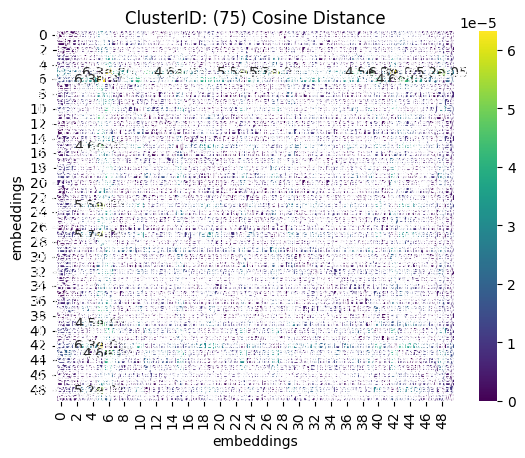

In [ ]:
computepairwisedistance.plot_heat_map(c_id=c_id, cluster=c_id_cluster)

In [ ]:
new_df[new_df['cluster_id']==320].head(10)

,file_names,embeddings,cluster_id
837,9843.webm,"[-0.45703125, -0.043548583984375, -0.480712890...",320
2335,11344.webm,"[-0.341796875, 0.452880859375, -0.119506835937...",320
4771,13792.webm,"[-0.2222900390625, 0.085693359375, -0.05581665...",320
6396,15422.webm,"[-0.49462890625, 0.2403564453125, -0.397705078...",320
8349,17382.webm,"[-0.35986328125, 0.1915283203125, 0.0464172363...",320
8387,17420.webm,"[-0.332275390625, 0.33642578125, -0.1517333984...",320


# TRY KMEANS